In [10]:
import scipy as sp
from sklearn.metrics import pairwise_distances

# ---------------------------------------------
def calc_AD_kmean_dist(train_dset, pred_dset, k, train_dset_pair_distance=None, dist_metric="euclidean"):
    """
    calculate the probability of the prediction dataset fall in the the domain of traning set. Use Euclidean distance of the K nearest neighbours.
    train_dset and pred_dset should be in 2D numpy array format where each row is a compound.
    """
    if train_dset_pair_distance is None:
        # calcualate the pairwise distance of training set
        train_dset_pair_distance = pairwise_distances(X=train_dset, metric=dist_metric)
    train_kmean_dis = []
    for i in range(len(train_dset_pair_distance)):
        kn_idx = np.argpartition(train_dset_pair_distance[i], k+1)
        dis = np.mean(train_dset_pair_distance[i][kn_idx[:k+1]])
        train_kmean_dis.append(dis)
    train_dset_distribution = sp.stats.norm.fit(train_kmean_dis)
    # pairwise distance between train and pred set
    pred_size = len(pred_dset)
    train_pred_dis = pairwise_distances(X=pred_dset, Y=train_dset, metric=dist_metric)
    pred_kmean_dis_score = np.zeros(pred_size)
    for i in range(pred_size):
        pred_km_dis = np.mean(np.sort(train_pred_dis[i])[:k])
        train_dset_std = train_dset_distribution[1] if train_dset_distribution[1] != 0 else 1e-6
        pred_kmean_dis_score[i] = max(1e-6, (pred_km_dis - train_dset_distribution[0]) / train_dset_std)
    return pred_kmean_dis_score

In [11]:
neks = ['NEK2_binding', 'NEK2_inhibition', 'NEK3_binding', 'NEK5_binding', 'NEK9_binding', 'NEK9_inhibition'] 
nek_list = ["2", "3", "5", "9"]
nektype = ['binding','inhibition']
feat_types = ['moe', 'mfp']
samplings = ['scaled', 'UNDER' , 'SMOTE', 'ADASYN']
model_types = ['RF','RF_BCW', 'BRFC', 'BRFC_BCW']
col_names = ['prediction_type', 'ADdist', 'model_type']
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
category_order = ['TP', 'TN', 'FP', 'FN']
k=7

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def swarm_varx_ADy_simple(df, true_labels, title, figure_path, filename):
    # Create a new column 'Varience of prediction' based on 'prediction_type'
    df['Varience of prediction'] = df.apply(
        lambda row: row['var0'] if row['prediction_type'] in ['TN', 'FN'] else row['var1'], axis=1
    )
    
    # Prepare data for plotting
    data = {
        'Varience of prediction': df['Varience of prediction'],
        'Prediction Type': df['prediction_type'],
        'ADdist': df['ADdist']
    }
    plot_df = pd.DataFrame(data)
    category_order = sorted(plot_df['Prediction Type'].unique())
    
    # Normalize the color scale for ADdist
    norm1 = plt.Normalize(plot_df['ADdist'].min(), plot_df['ADdist'].max())
    sm1 = plt.cm.ScalarMappable(cmap="viridis", norm=norm1)
    sm1.set_array([])

    # Create the plot
    plt.figure(figsize=(10, 6))
    ax = sns.stripplot(x='Prediction Type', y='ADdist', data=plot_df, hue='Varience of prediction', order=category_order, dodge=True, palette="viridis")
    
    for artist in ax.collections:
        artist.set_edgecolor('black')
        facecolors = artist.get_facecolors()
        for i, fc in enumerate(facecolors):
            fc[:] = sm1.to_rgba(plot_df['Varience of prediction'].iloc[i])

    # Add colorbar
    cbar1 = plt.colorbar(sm1, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
    cbar1.set_label('Varience of Prediction')
    if ax.legend_:
        ax.legend_.remove()
    plt.title(title)
    plt.xlabel('Prediction Type')
    plt.ylabel('ADdist')

 
        
    plt.show()

GPpath = '/Users/radhi/Desktop/CAPSTONE_DATA/GP_results/GP_result_df/'
col_names = ['prediction_type', 'ADdist', 'model_type']
model_palette = sns.cubehelix_palette(start=.5, rot=-.5, n_colors=2)
category_order = ['TP', 'TN', 'FP', 'FN']
figure_path = '/Users/radhi/Desktop/atom2024/atom2024/notebooks/NEK/plots/AD/figures/AD_GP_var/'

for nek in nek_list:
    for feat in feat_types: 
        for samp in samplings: 
            df_path = f'/Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK{nek}/bind/'
            full_df = pd.read_csv(f'{df_path}NEK{nek}_binding_{feat}_{samp}_df.csv') 
            train_df = full_df[full_df['subset'] == 'train'].select_dtypes(include=numerics).drop(columns=['active'])
            test_df = full_df[full_df['subset'] == 'test'].select_dtypes(include=numerics).drop(columns=['active'])
            test_dist = calc_AD_kmean_dist(train_df, test_df, k)
            train_dist = calc_AD_kmean_dist(train_df, train_df, k)
         
            moe_pred = pd.read_csv(f'{GPpath}NEK{nek}_binding_moe_{samp}_test_GP.csv')
            mfp_pred = pd.read_csv(f'{GPpath}NEK{nek}_binding_mfp_{samp}_test_GP.csv')
            var0_moe = moe_pred['var_pred_class0'].to_numpy()
            var1_moe = moe_pred['var_pred_class1'].to_numpy()
            var0_mfp = mfp_pred['var_pred_class0'].to_numpy()
            var1_mfp  = mfp_pred['var_pred_class1'].to_numpy()
            moe_preds = moe_pred['y_pred']
            mfp_preds = mfp_pred['y_pred']
    
            true_labels = moe_pred['y'].to_numpy()

            moe_df = pd.DataFrame({'prediction': moe_preds, 'prediction_type': moe_pred['prediction_type'], 'var0': var0_moe, 'var1': var1_moe, 'ADdist': test_dist})
            mfp_df = pd.DataFrame({'prediction': mfp_preds, 'prediction_type': mfp_pred['prediction_type'], 'var0': var0_mfp, 'var1': var1_mfp, 'ADdist': test_dist})
            moe_df['feat_type'] = 'moe'
            mfp_df['feat_type'] = 'mfp' 

            if samp == 'scaled': 
                samp = 'raw'
            
            swarm_varx_ADy_simple(moe_df, true_labels, f'NEK{nek} moe binding {samp} GP', figure_path, f'NEK{nek}_binding_moe_{samp}_GP_AD')
            swarm_varx_ADy_simple(mfp_df, true_labels, f'NEK{nek} mfp binding {samp} GP', figure_path, f'NEK{nek}_binding_mfp_{samp}_GP_AD')

            if samp == 'raw': 
                samp = 'scaled'


/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 53.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 69.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


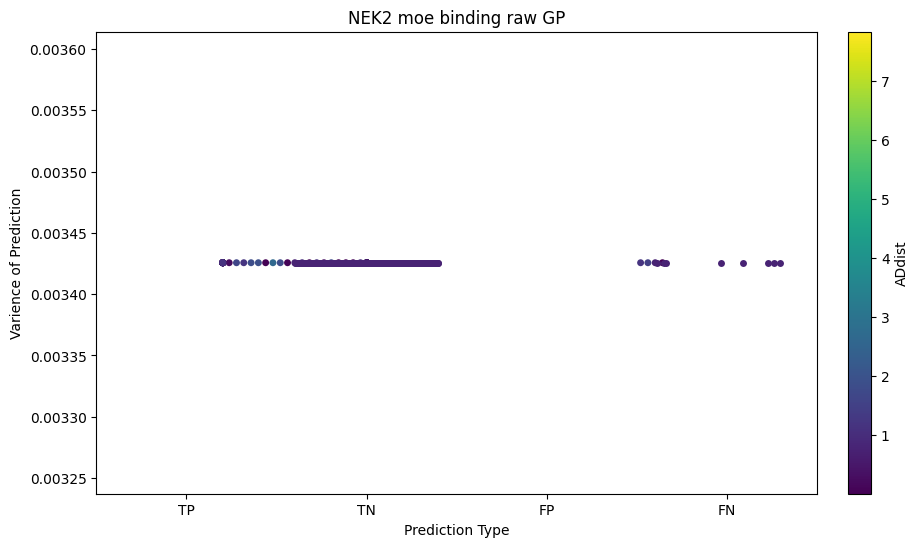

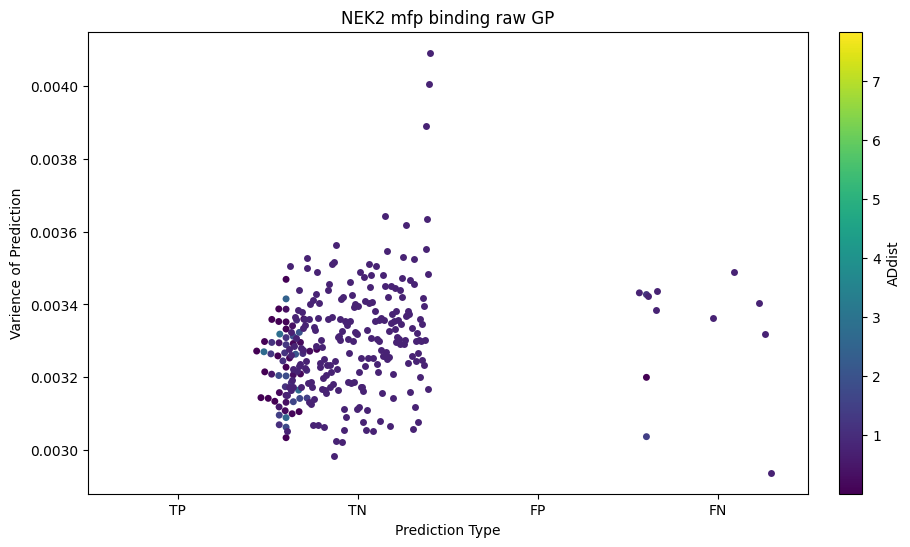

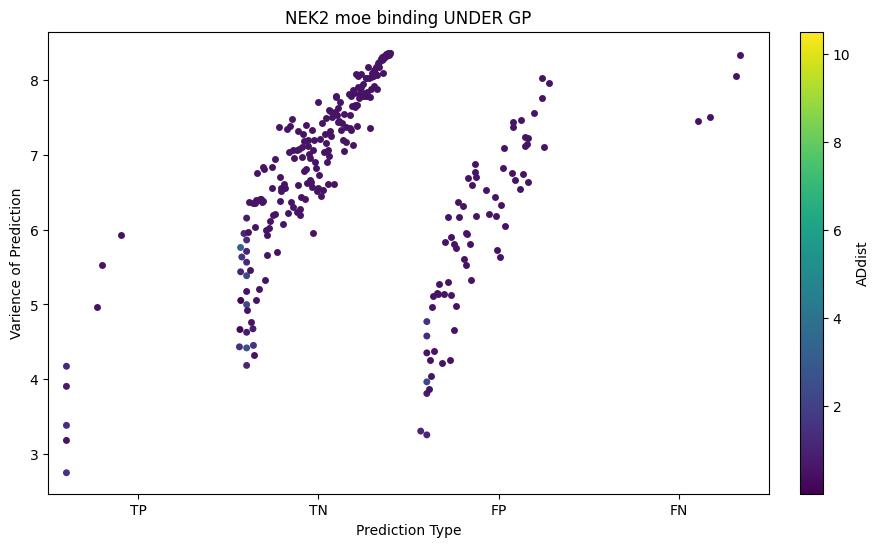

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 26.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


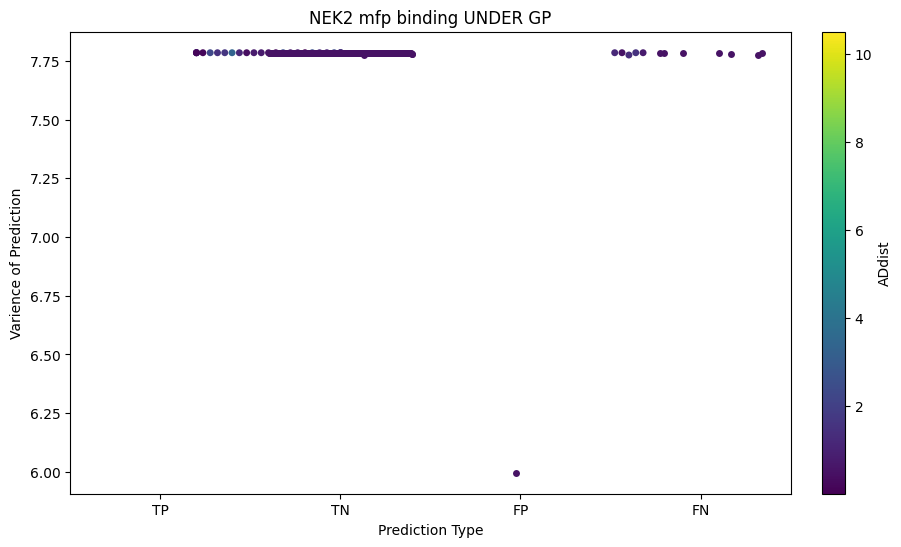

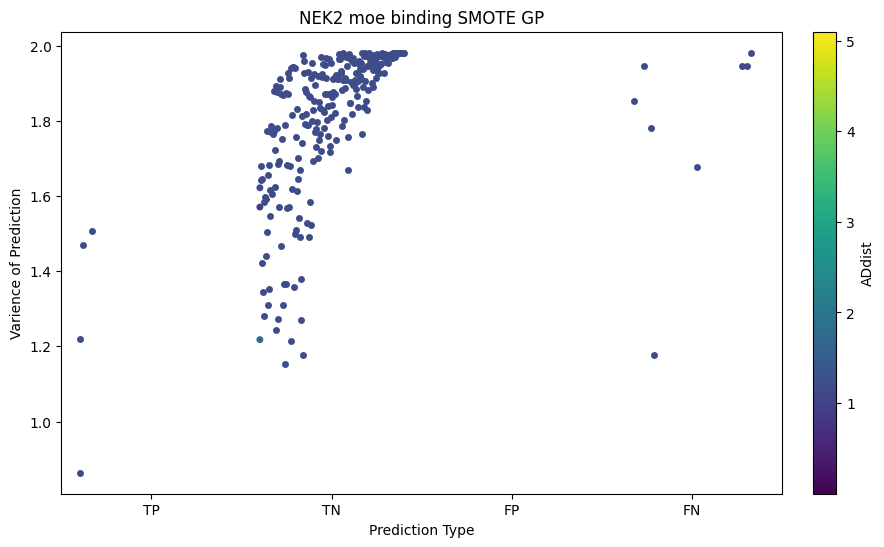

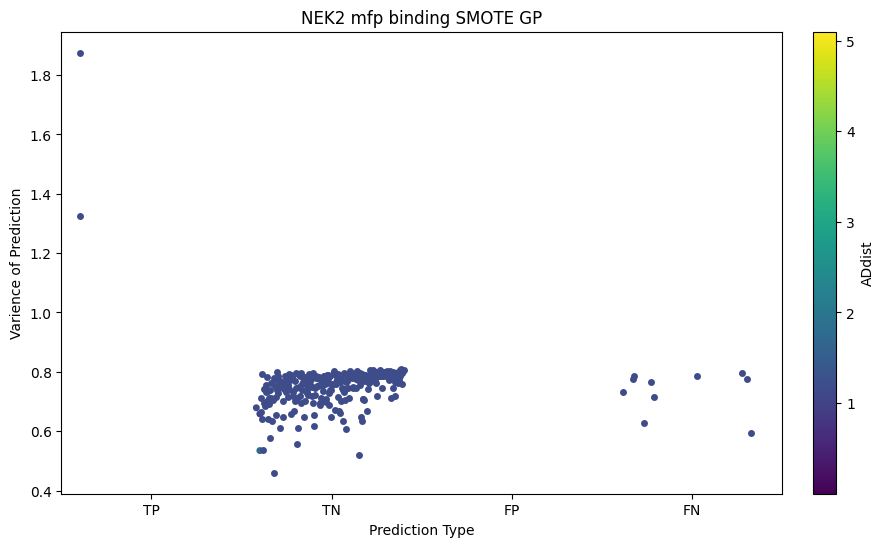

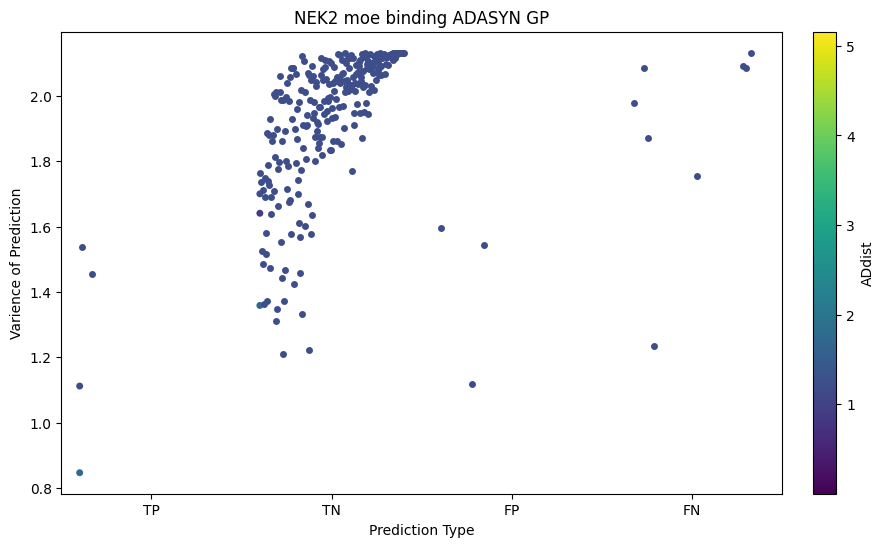

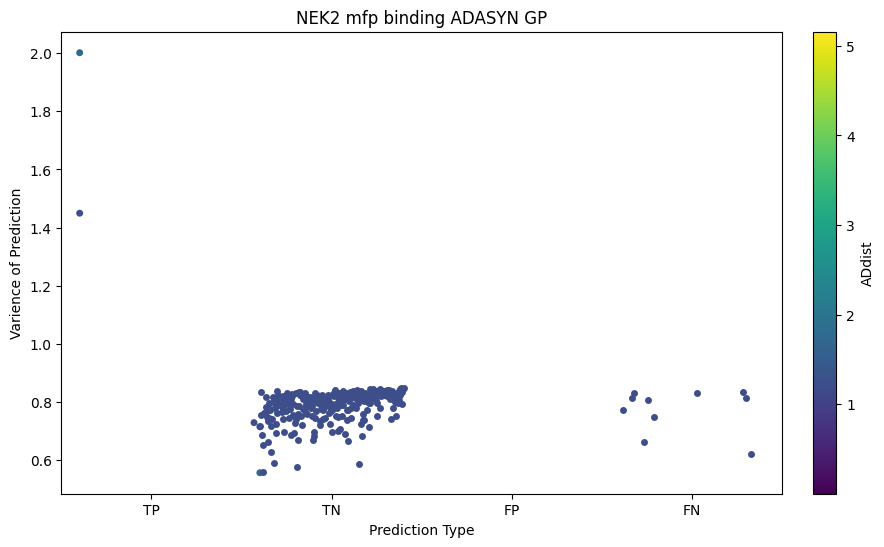

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 67.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 78.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


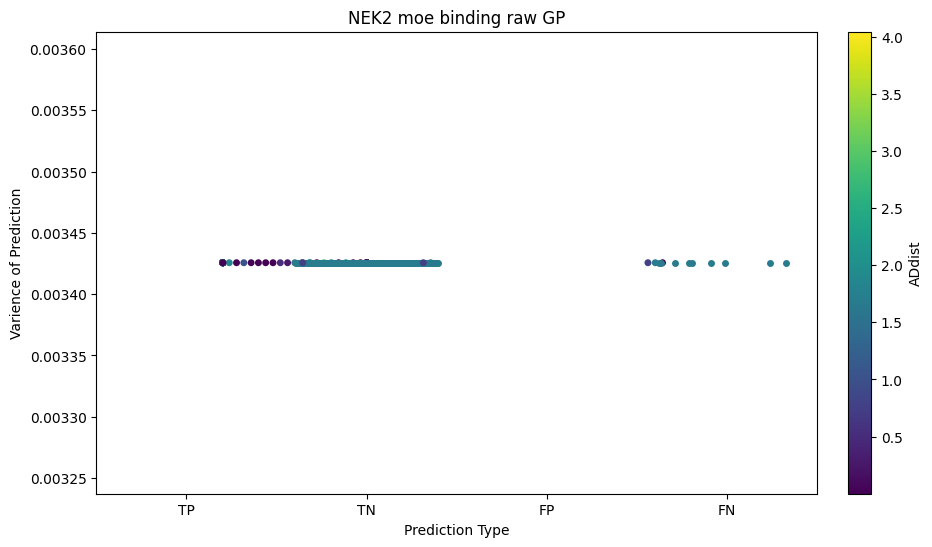

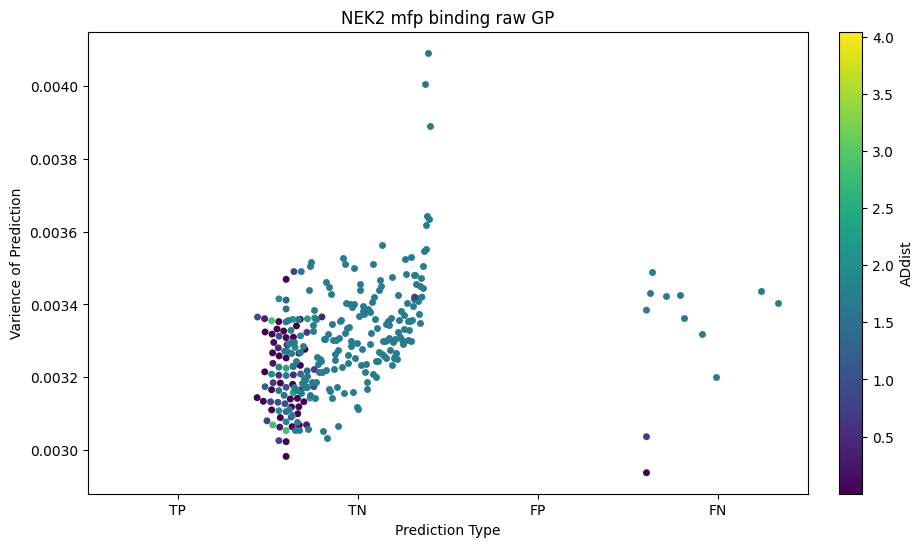

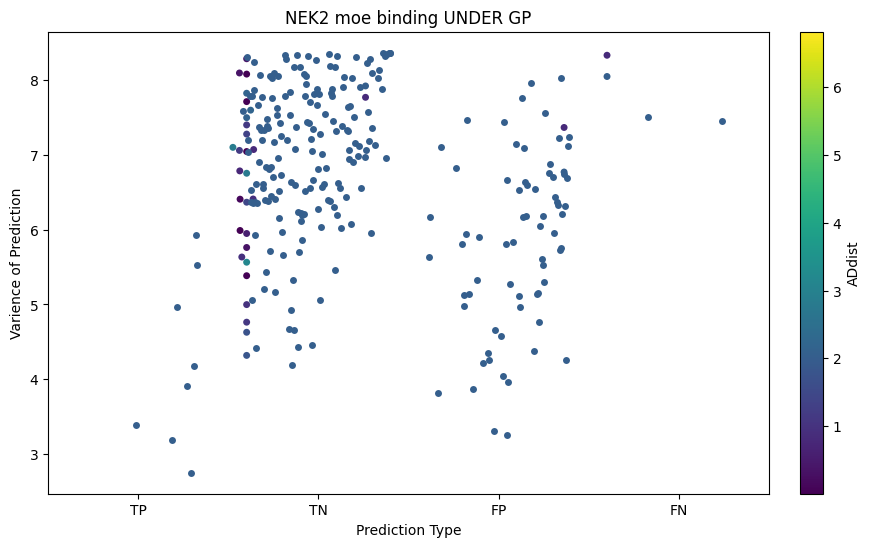

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 34.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


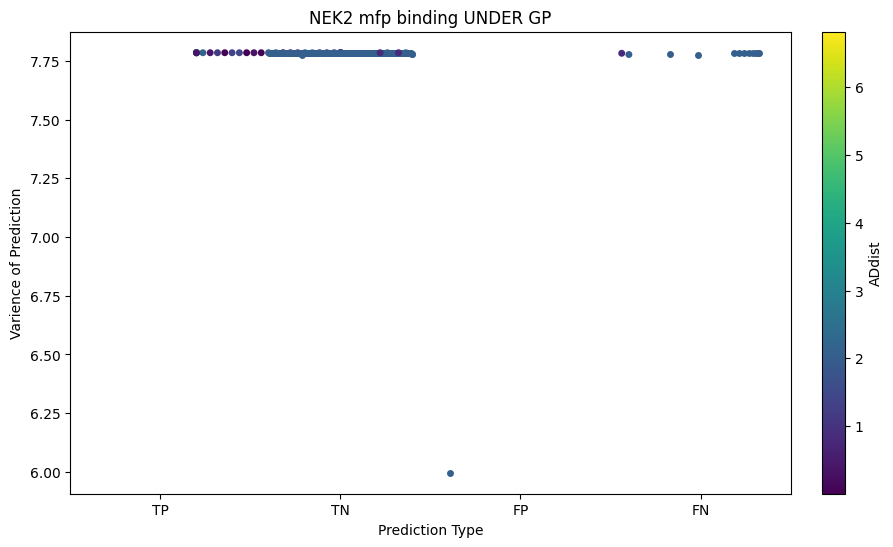

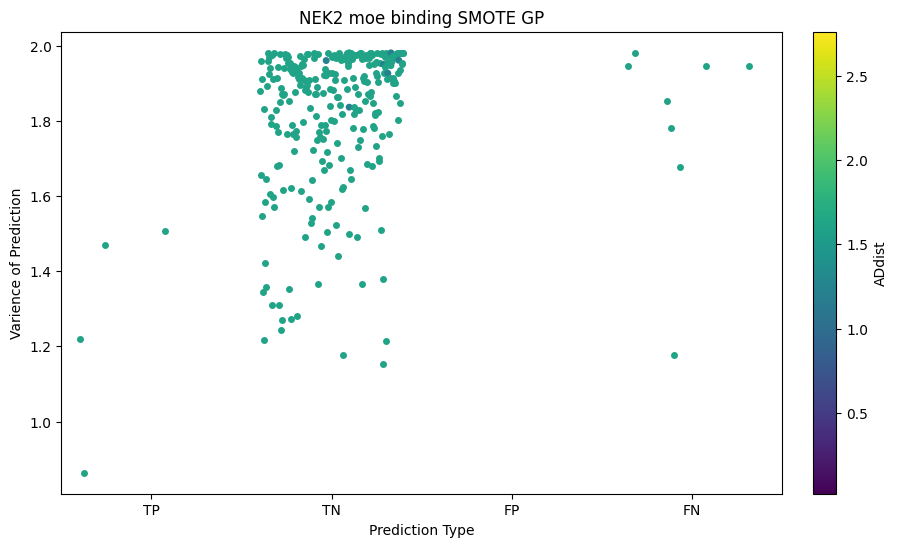

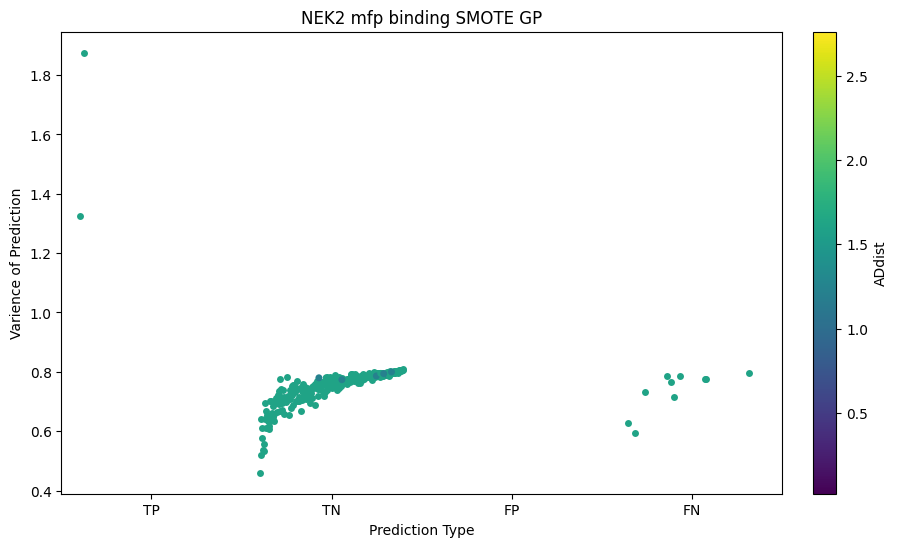

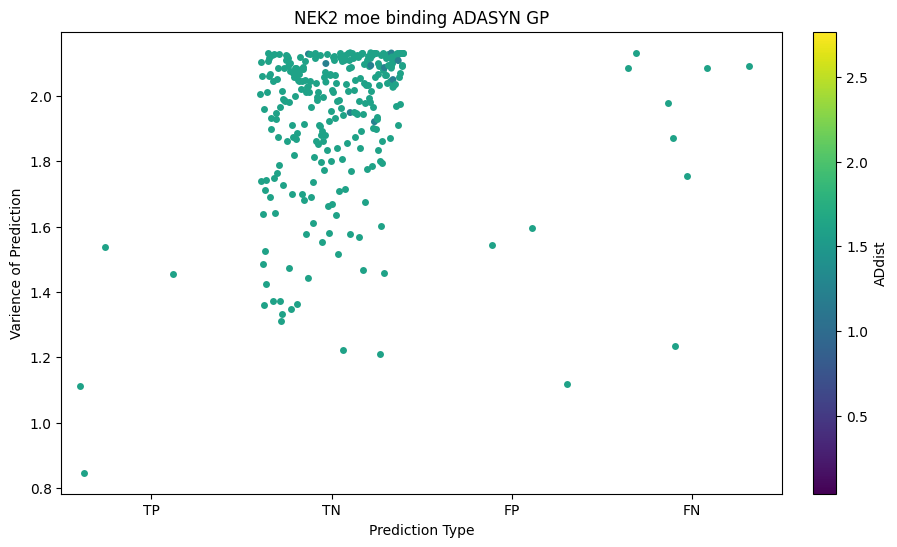

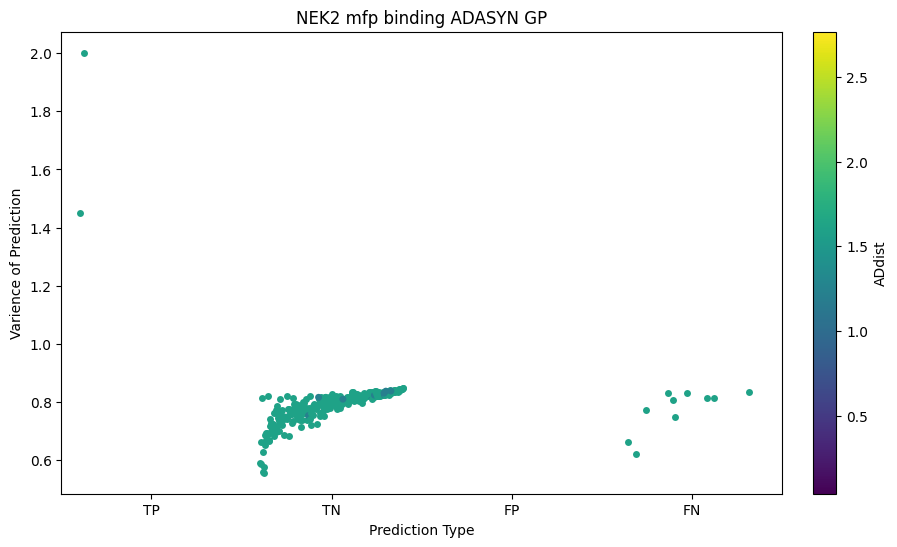

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 11.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 27.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


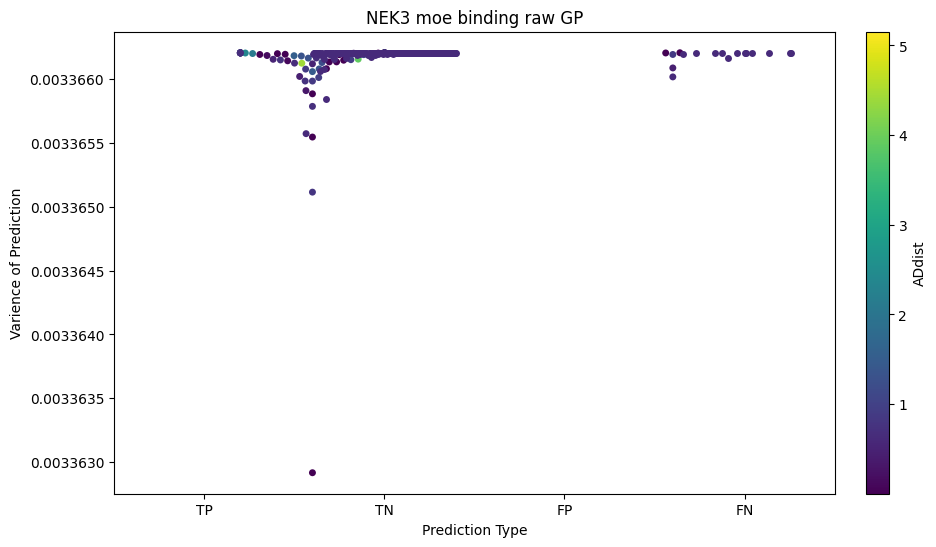

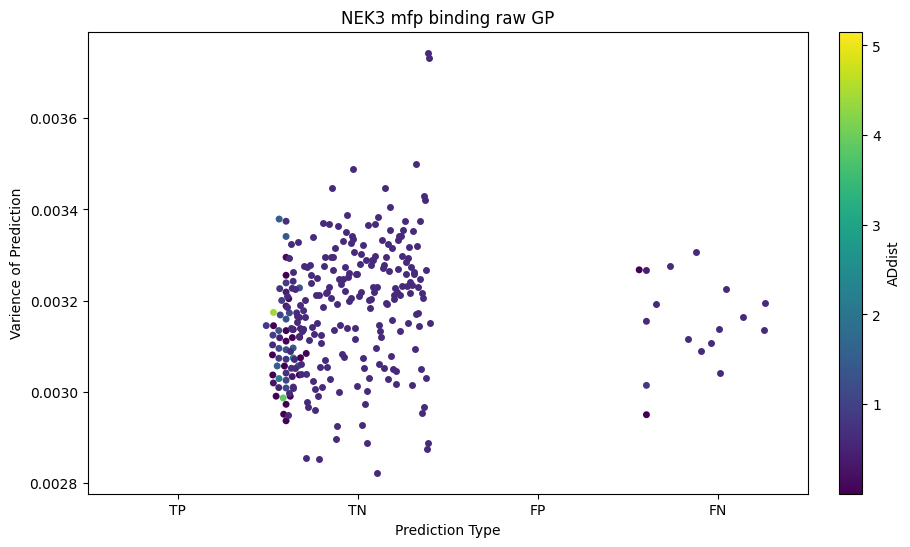

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 15.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


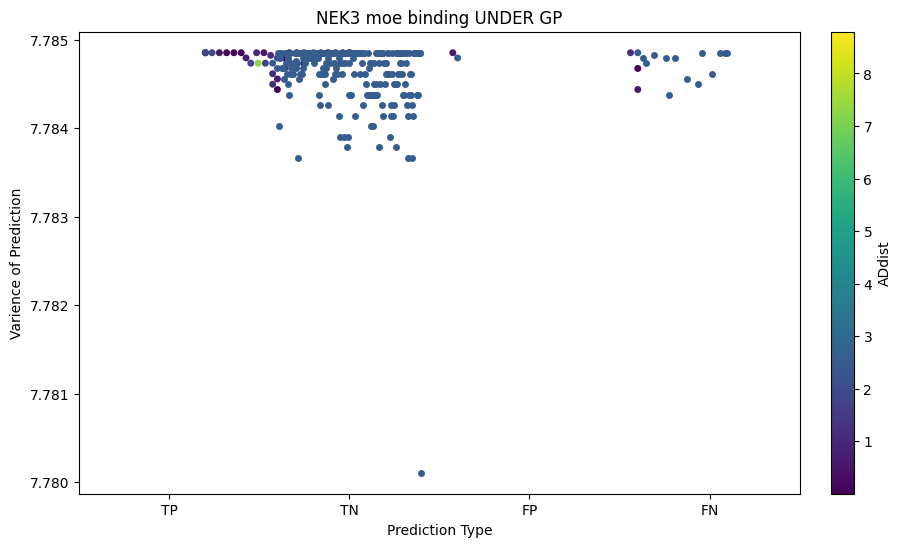

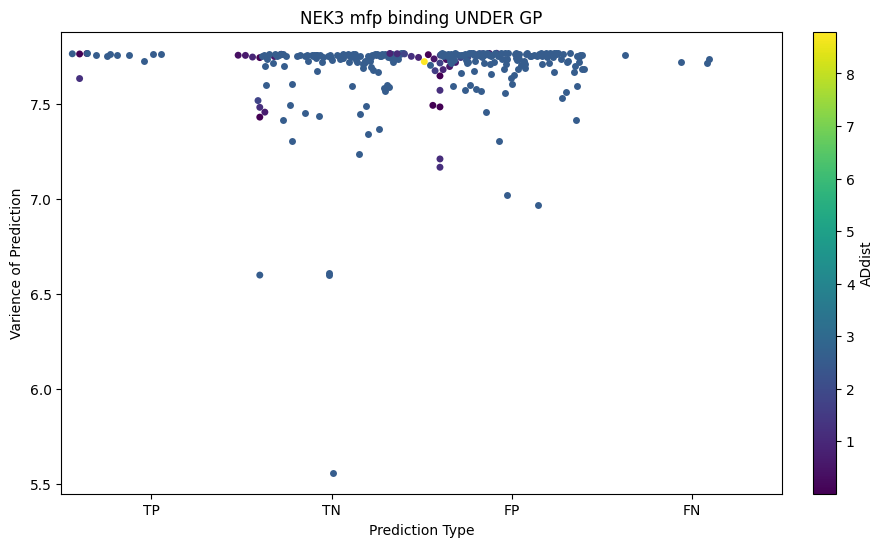

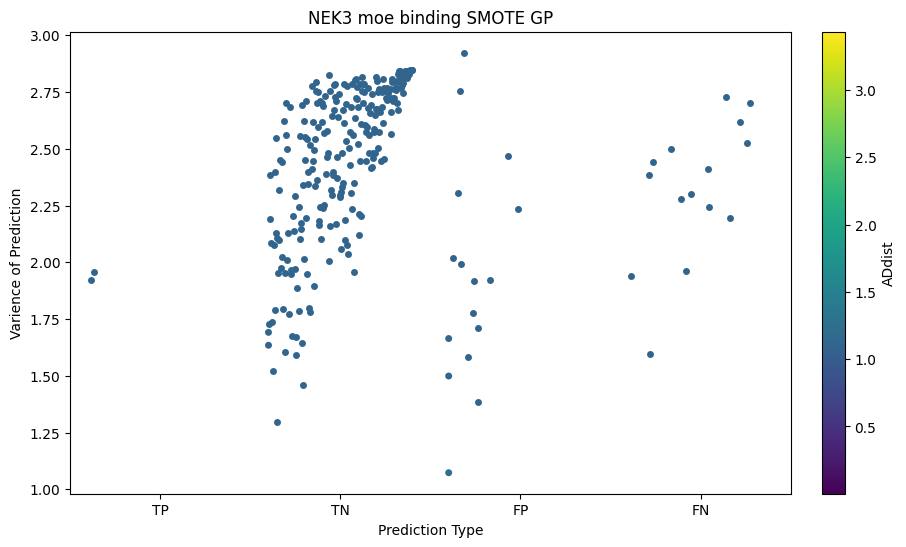

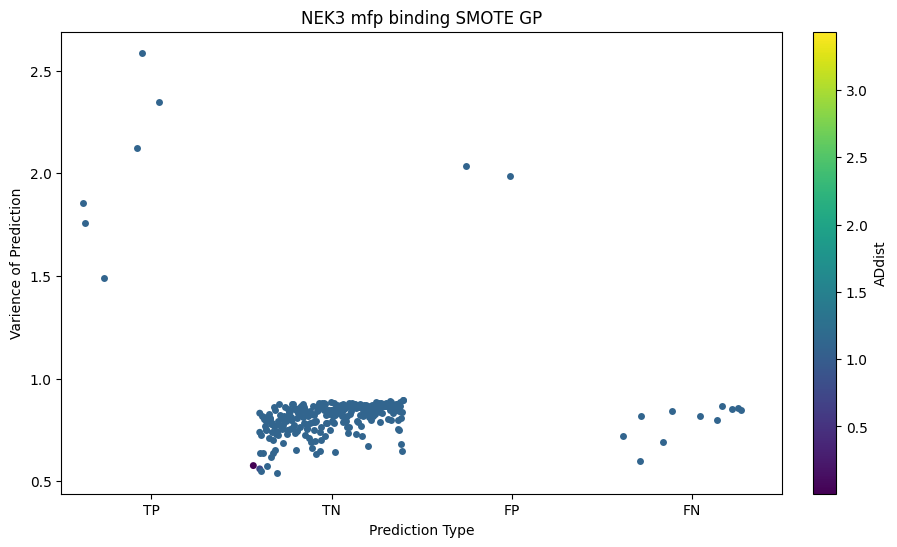

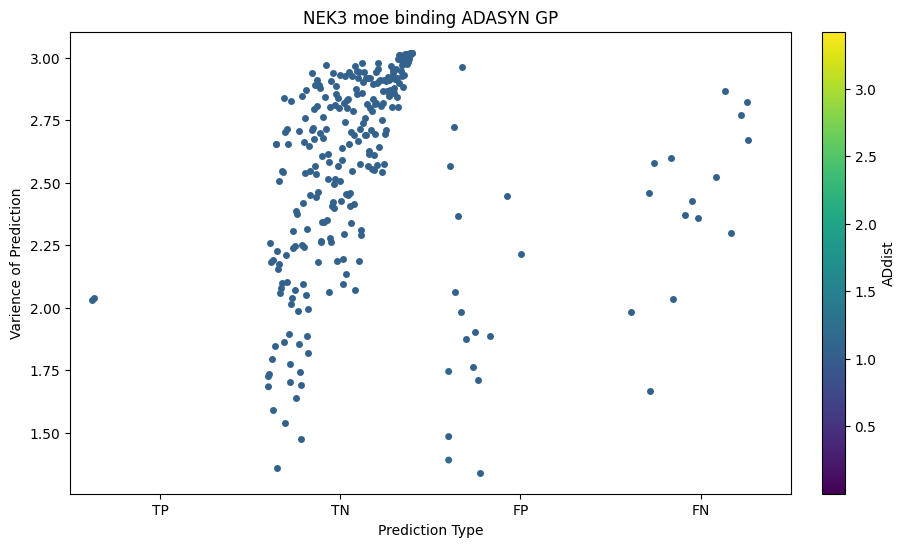

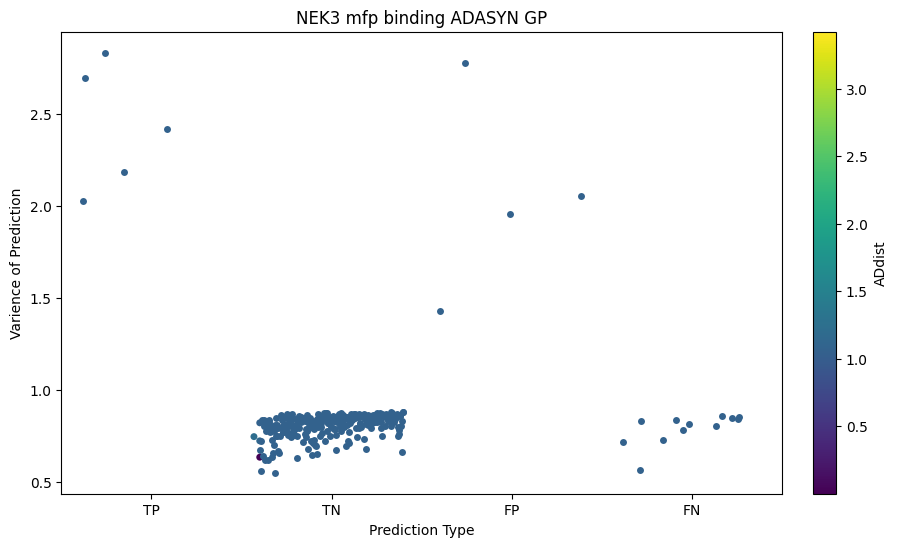

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 46.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 55.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


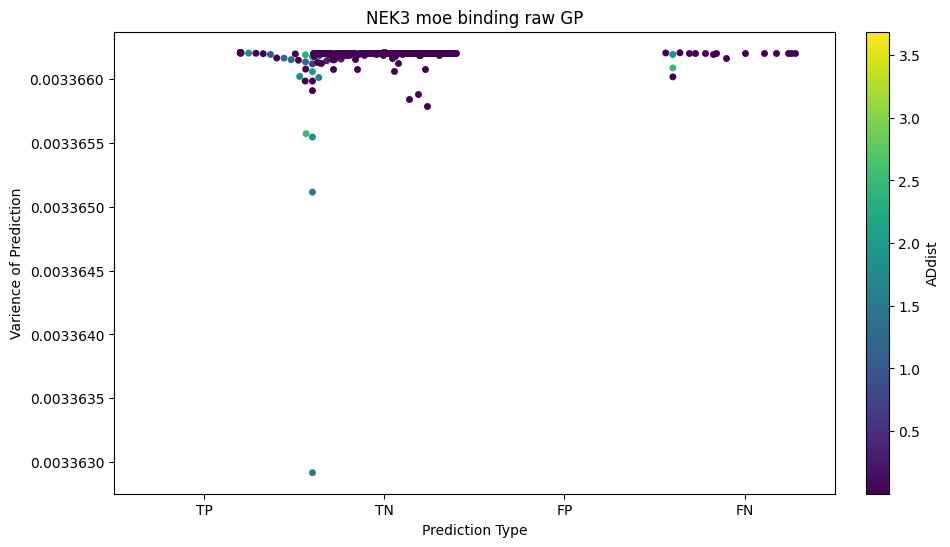

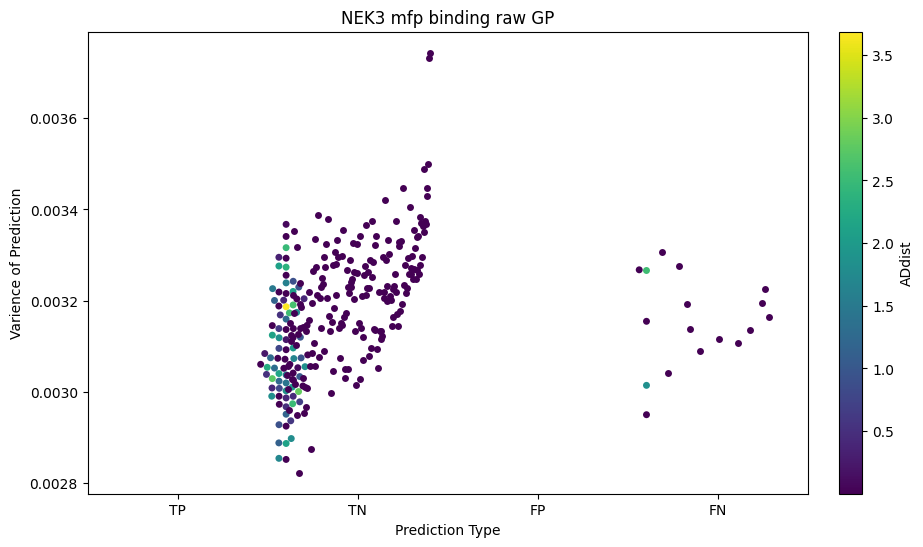

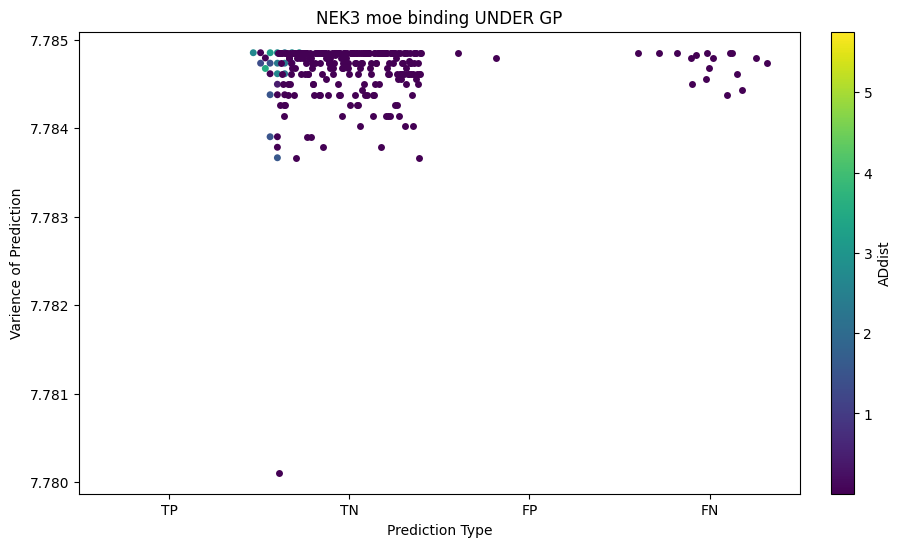

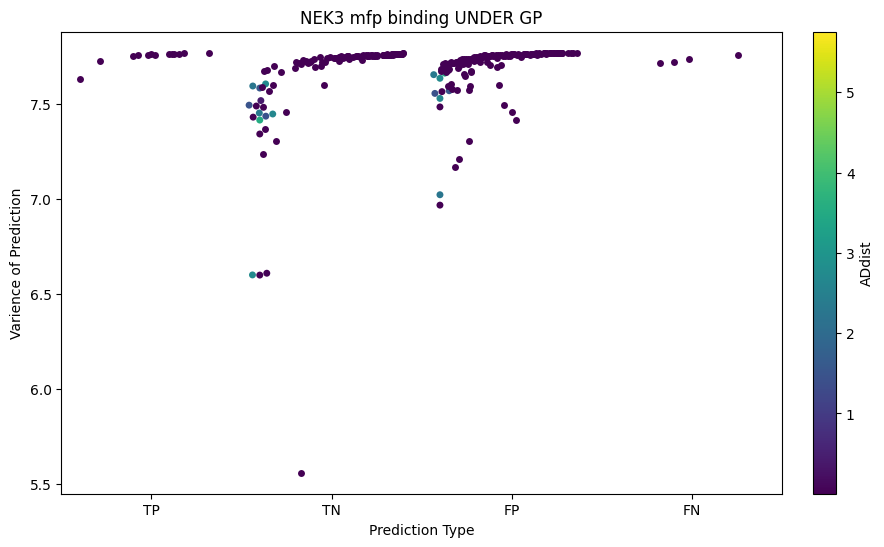

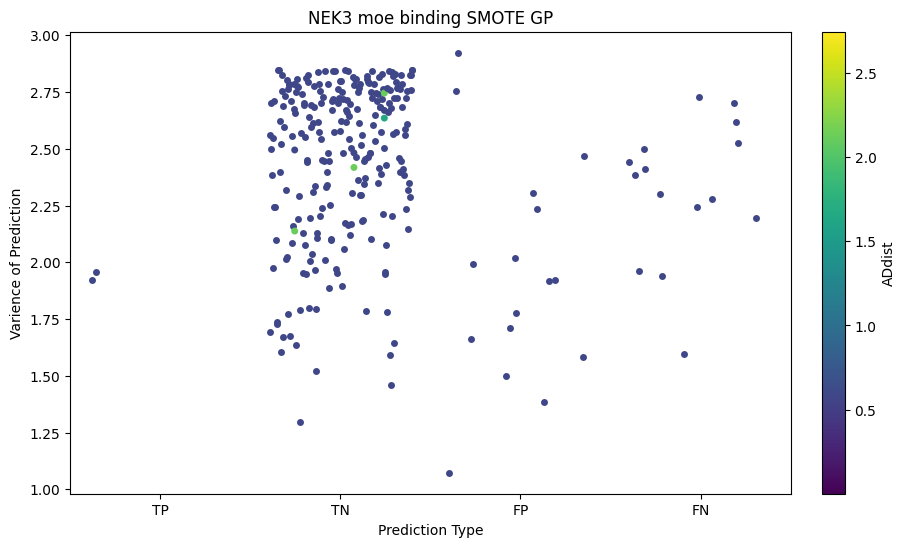

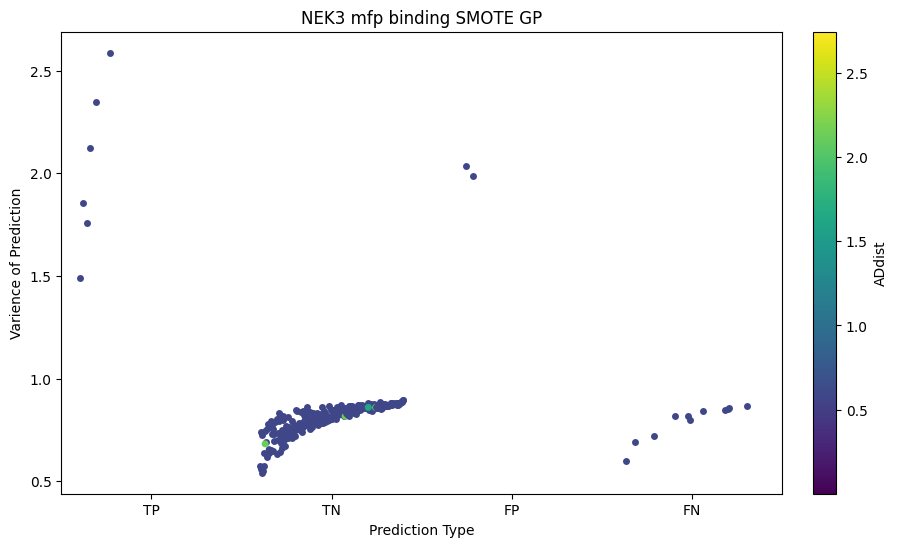

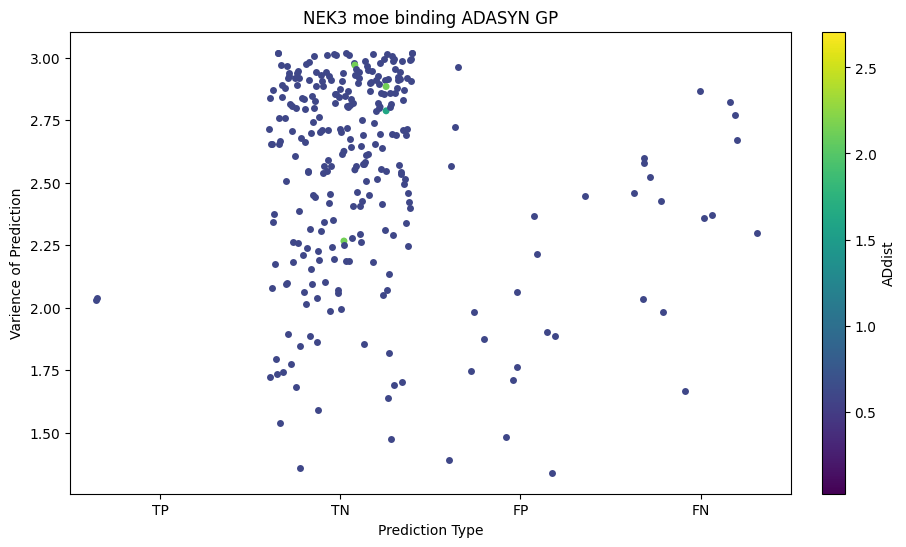

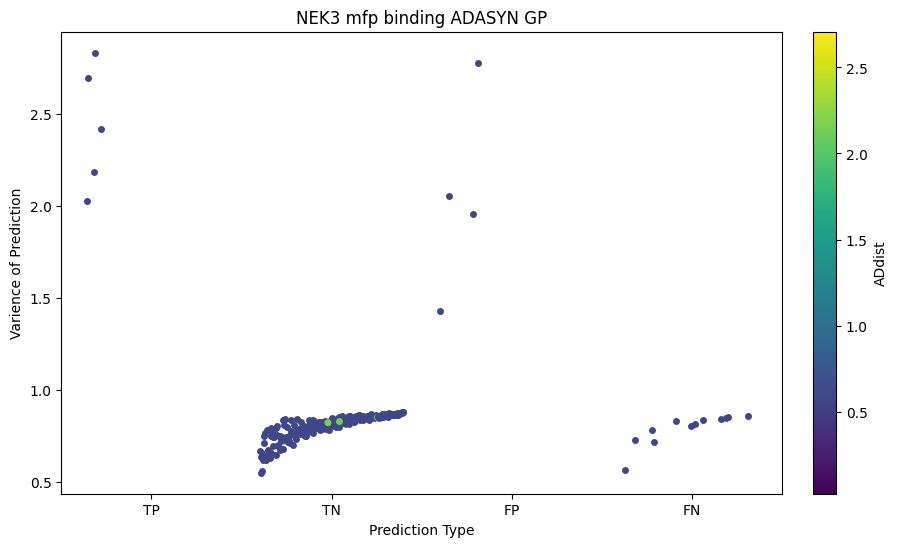

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 60.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 72.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 69.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 72.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


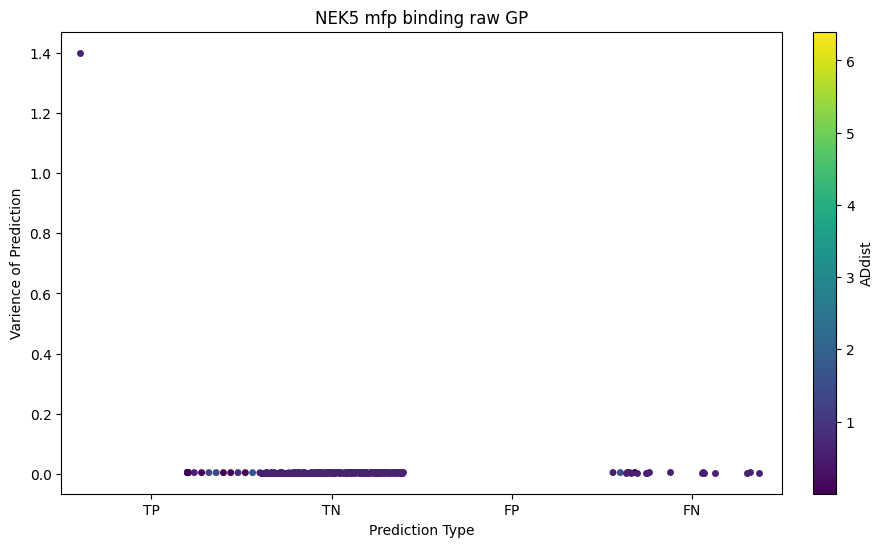

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 17.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


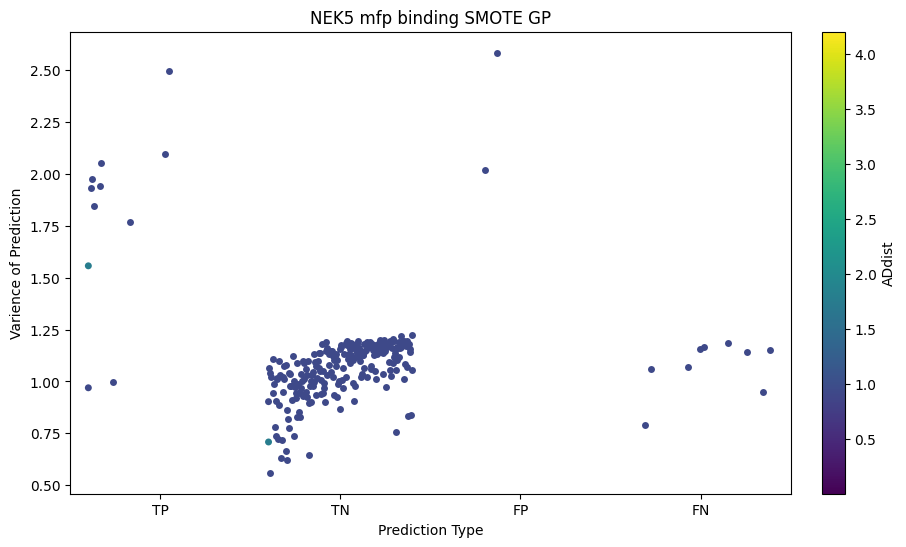

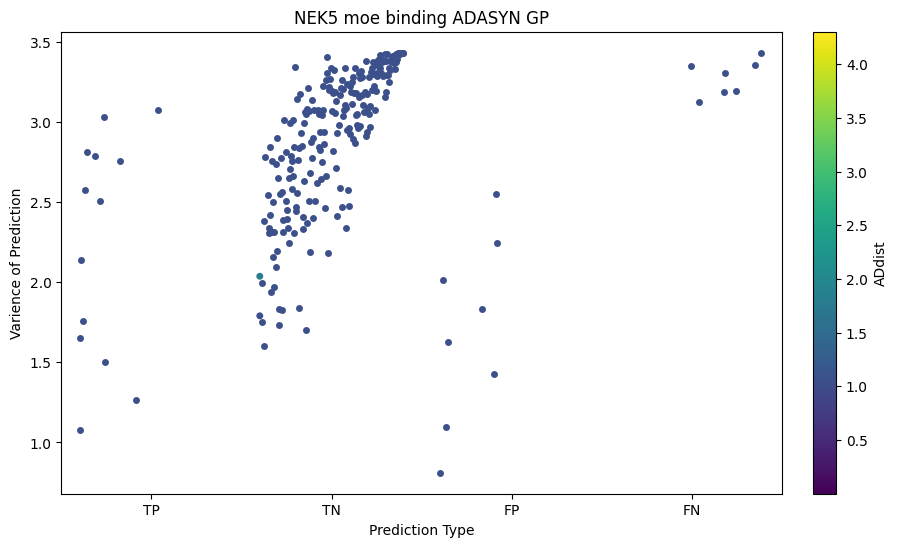

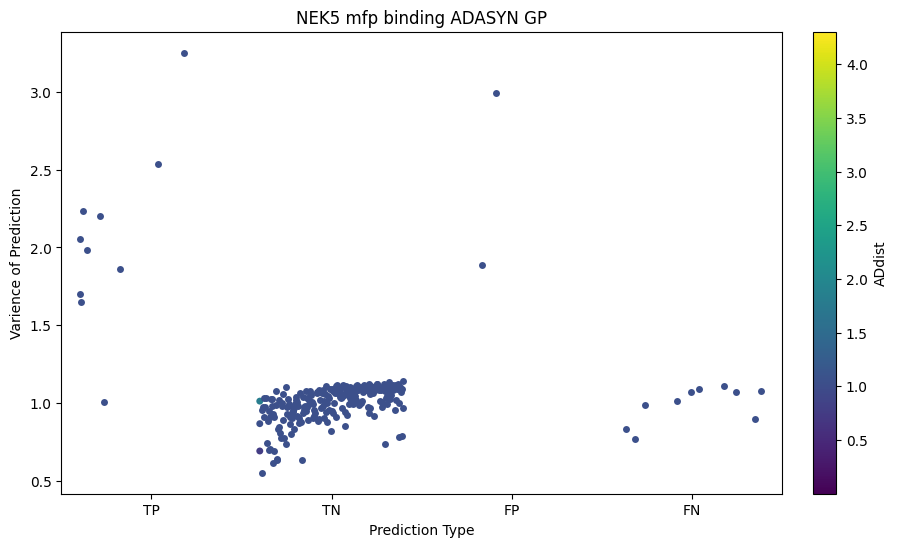

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 61.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 75.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 72.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 75.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 14.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 39.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


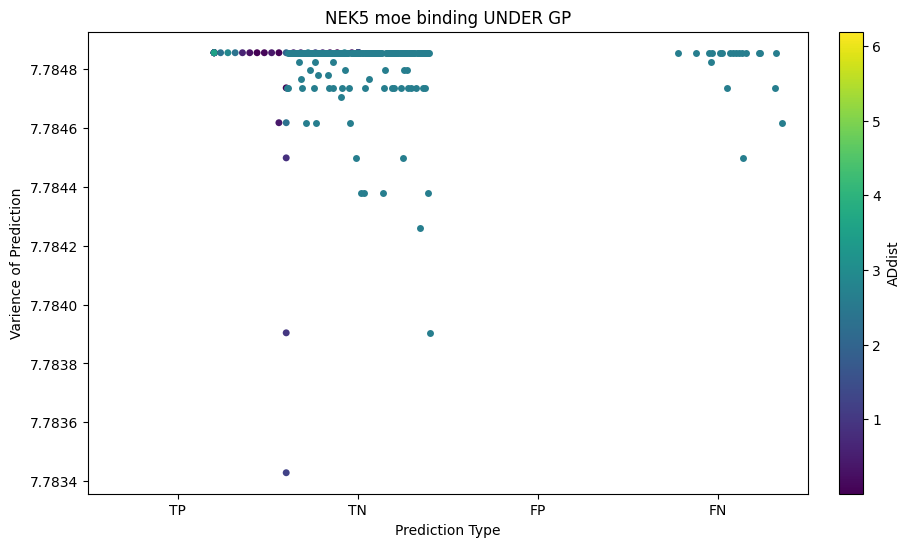

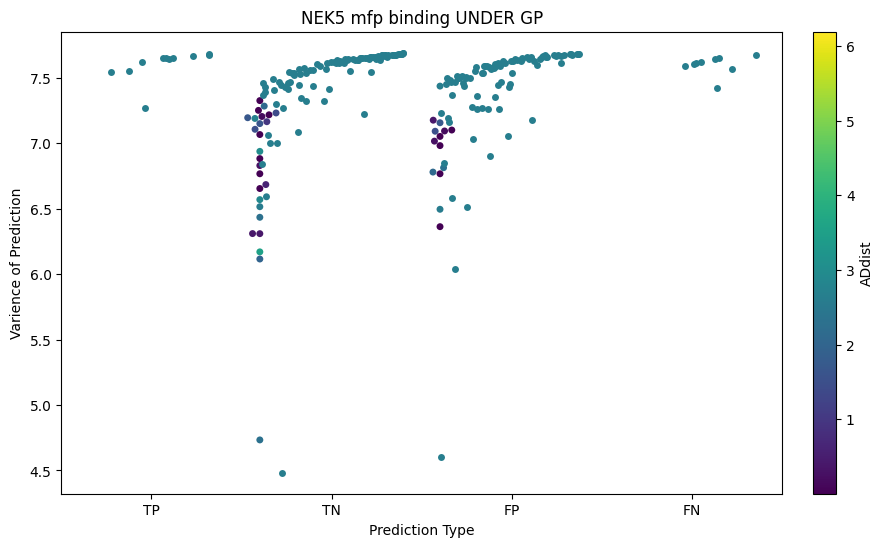

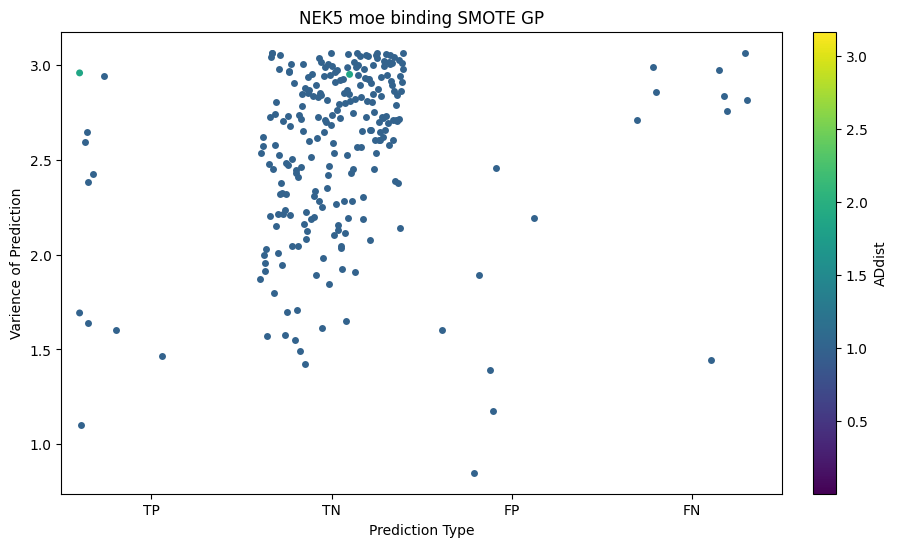

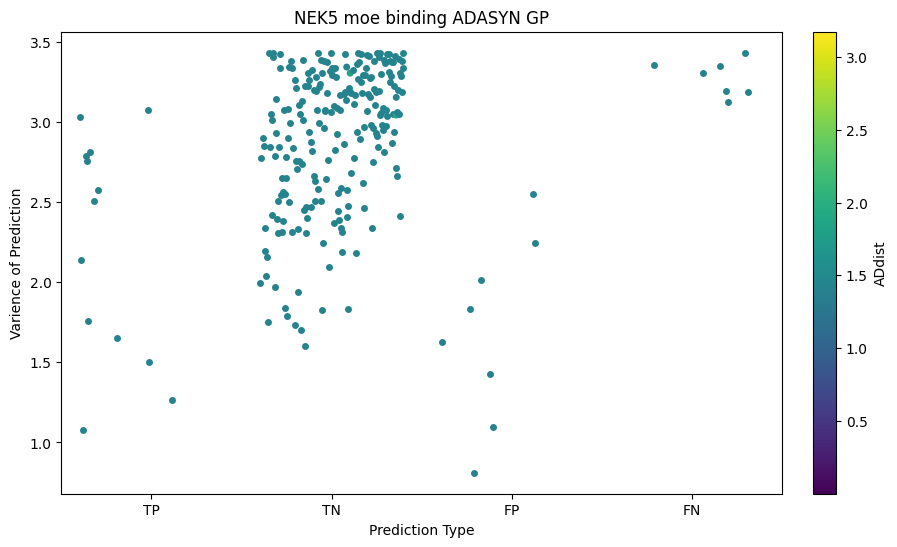

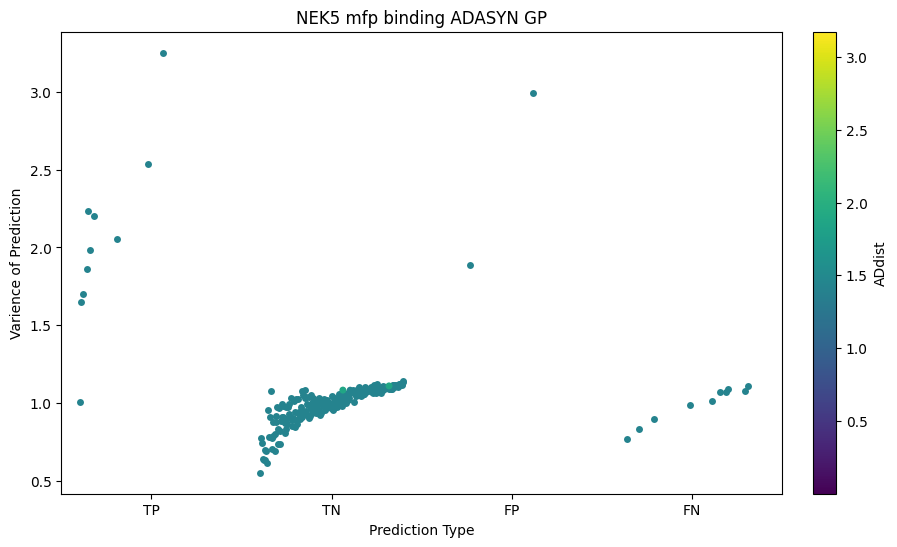

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 60.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 74.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


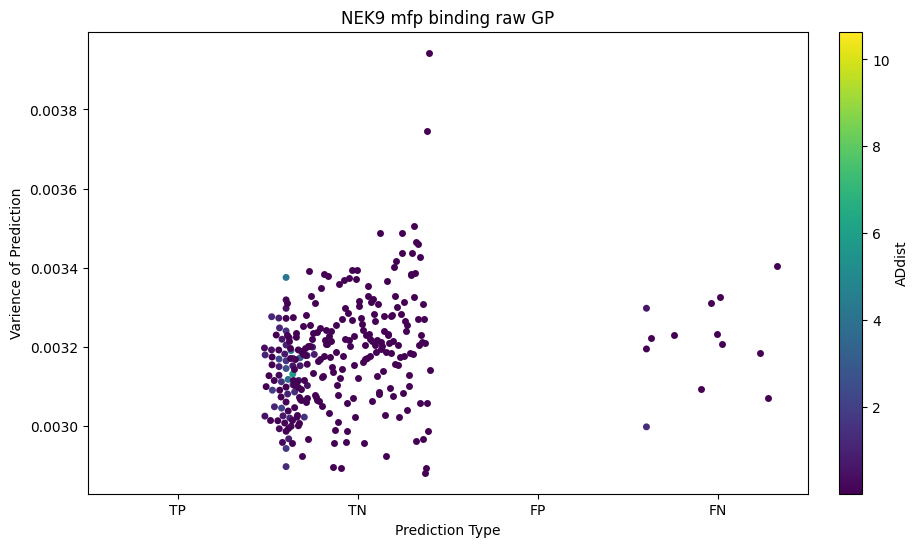

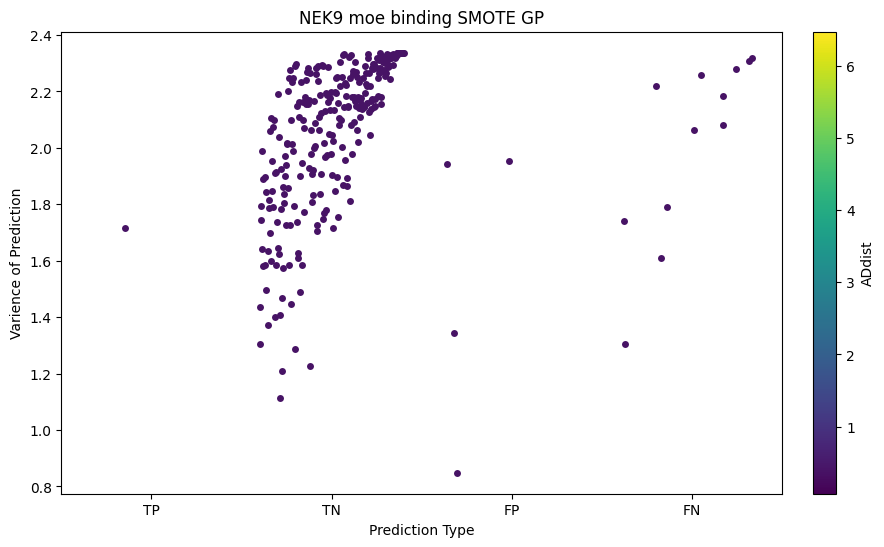

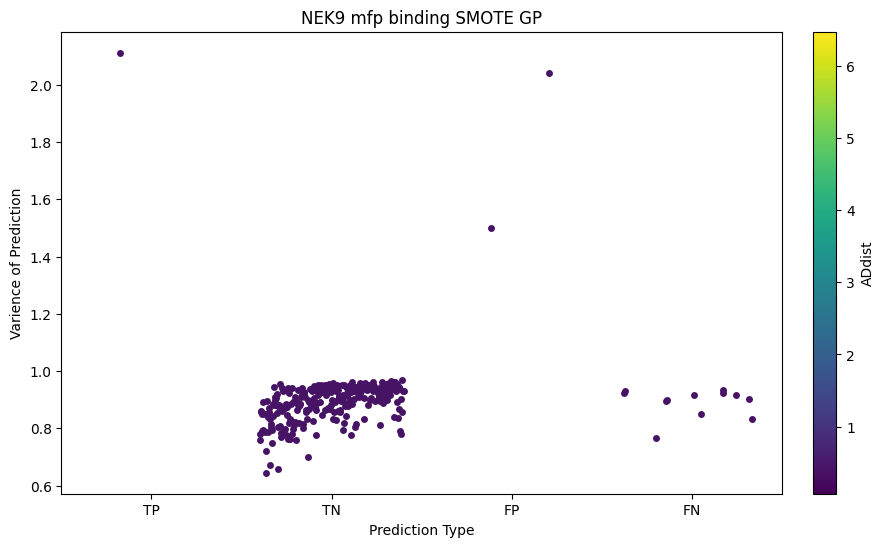

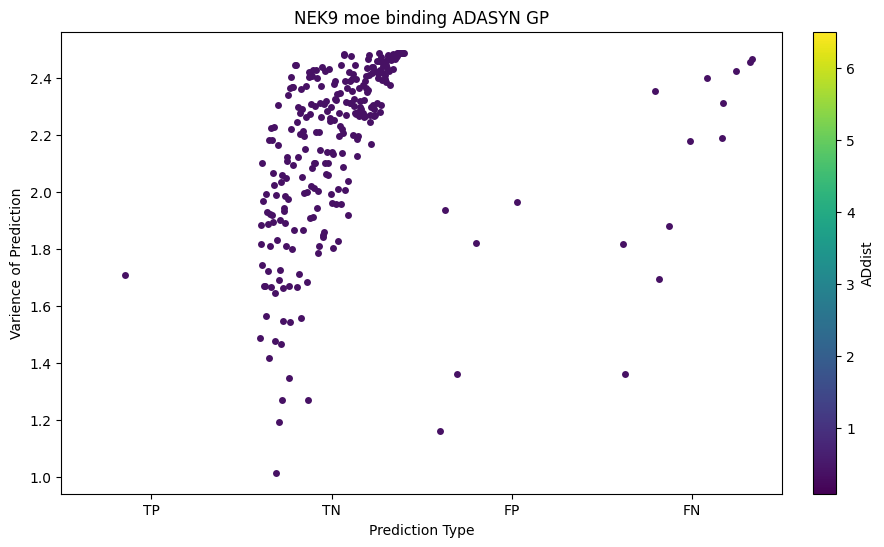

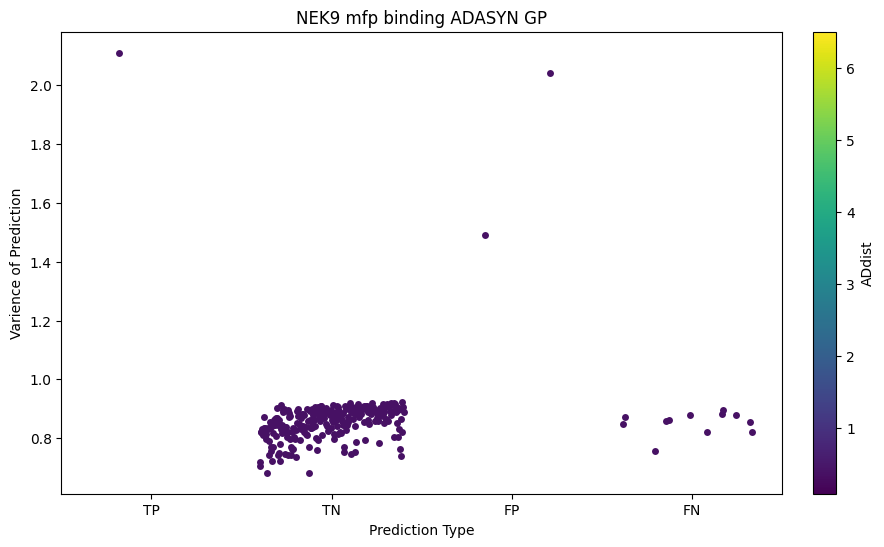

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 70.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 80.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


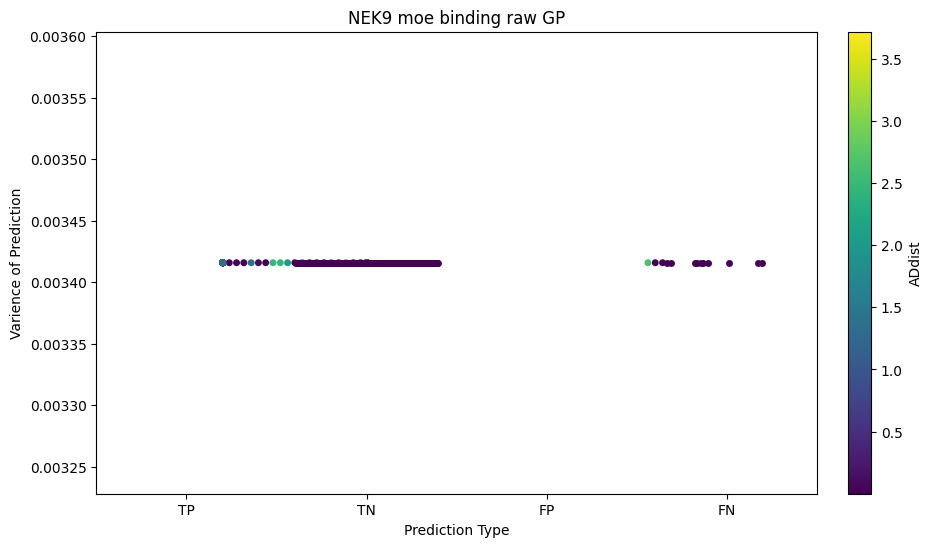

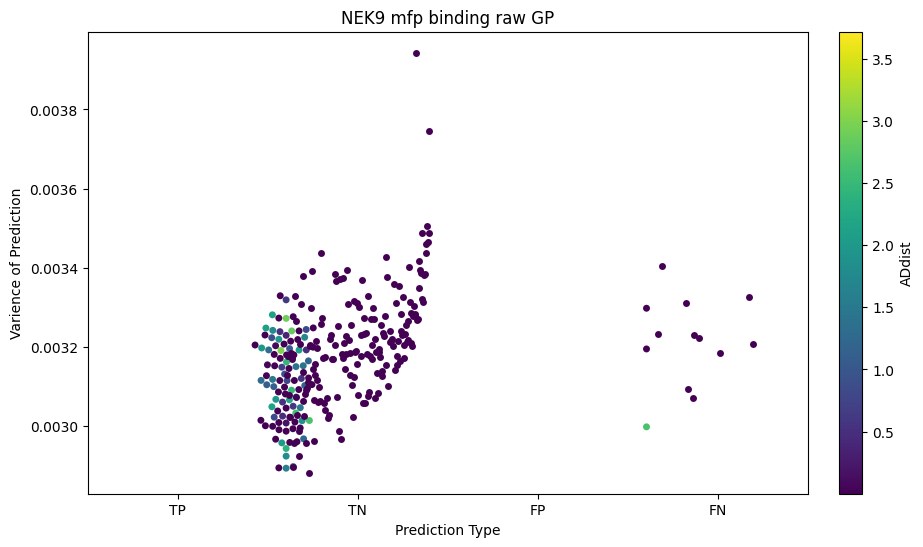

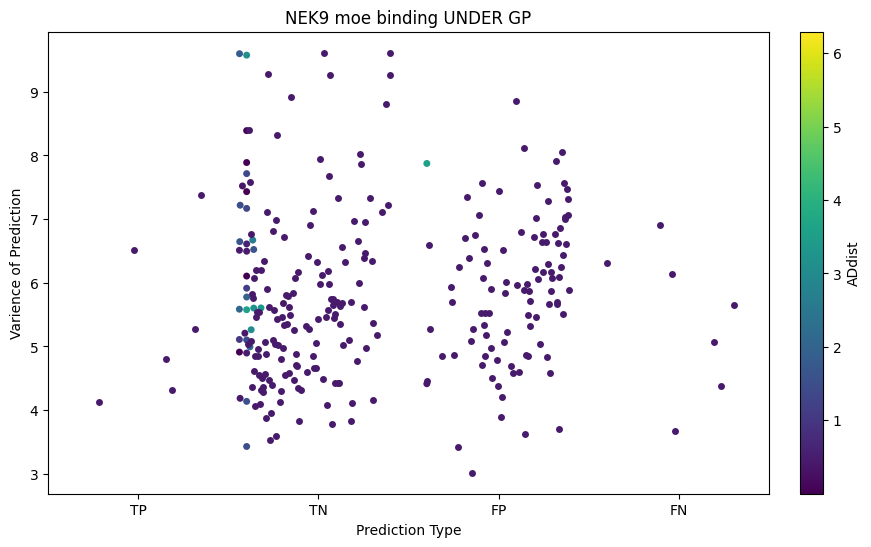

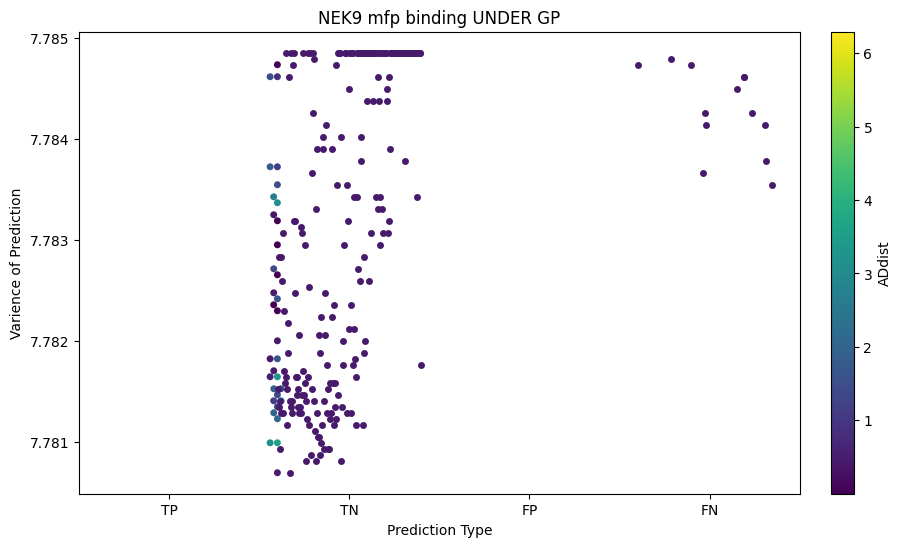

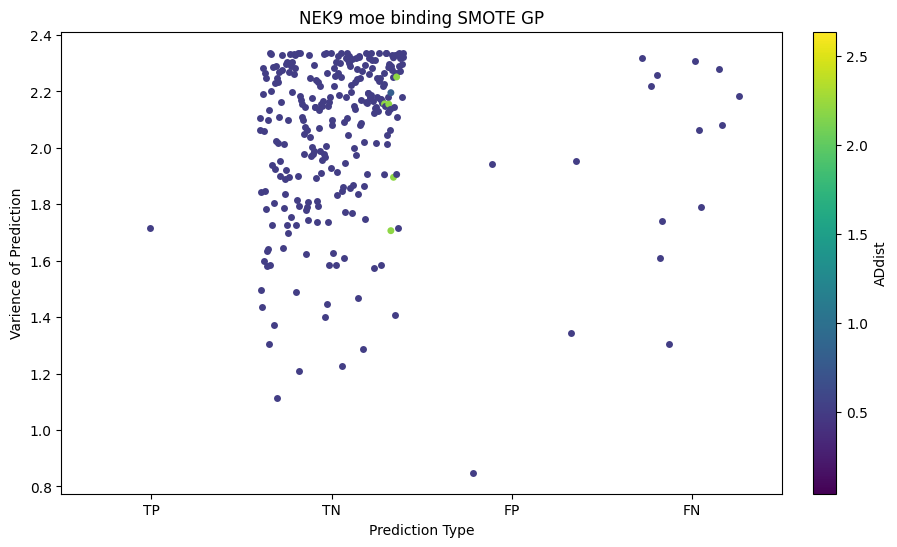

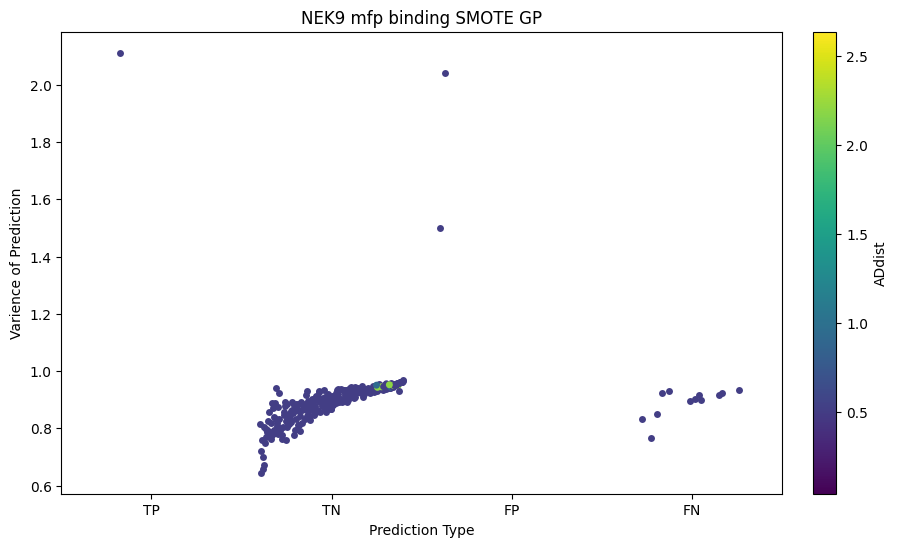

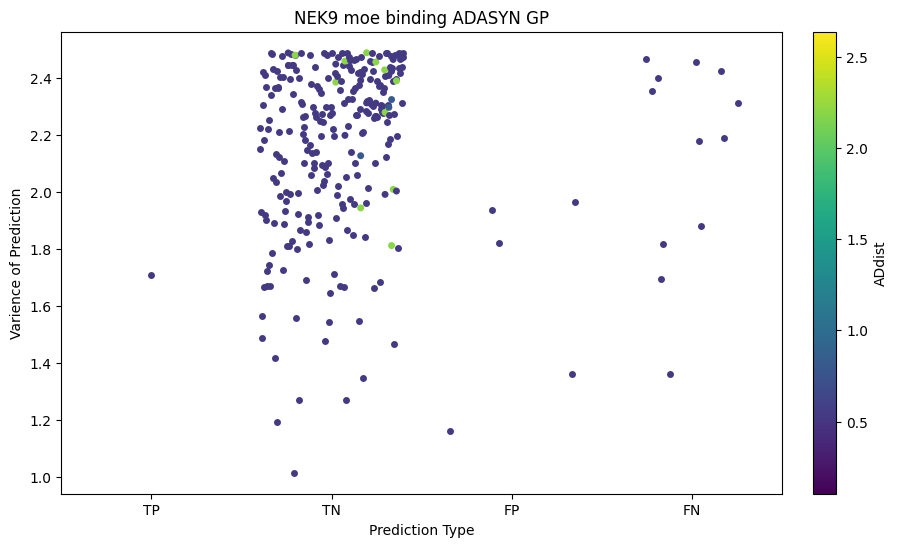

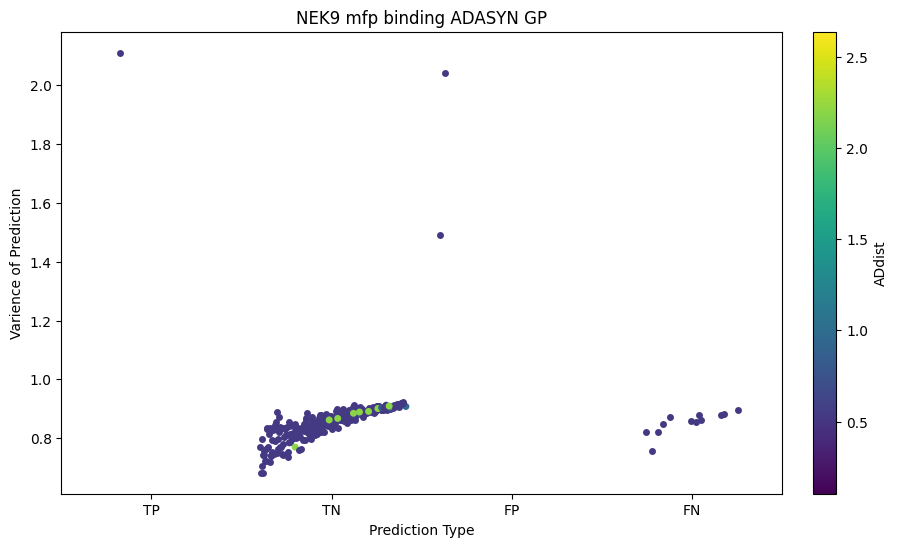

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def swarm_var_AD_simple(df, true_labels, title, figure_path, filename):
    # Create a new column 'Varience of prediction' based on 'prediction_type'
    df['Varience of prediction'] = df.apply(
        lambda row: row['var0'] if row['prediction_type'] in ['TN', 'FN'] else row['var1'], axis=1
    )
    
    # Prepare data for plotting
    data = {
        'Varience of prediction': df['Varience of prediction'],
        'Prediction Type': df['prediction_type'],
        'ADdist': df['ADdist']
    }
    plot_df = pd.DataFrame(data)
    category_order = sorted(plot_df['Prediction Type'].unique())
    
    # Normalize the color scale for ADdist
    norm1 = plt.Normalize(plot_df['ADdist'].min(), plot_df['ADdist'].max())
    sm1 = plt.cm.ScalarMappable(cmap="viridis", norm=norm1)
    sm1.set_array([])
    
    category_order = ['TP', 'TN', 'FP', 'FN']
    # Create the plot
    plt.figure(figsize=(10, 6))
    ax = sns.swarmplot(x='Prediction Type', y='Varience of prediction', data=plot_df, hue='ADdist', order=category_order, dodge=True, palette="viridis")
    
    for artist in ax.collections:
        artist.set_edgecolor('black')
        facecolors = artist.get_facecolors()
        for i, fc in enumerate(facecolors):
            fc[:] = sm1.to_rgba(plot_df['ADdist'].iloc[i])

    # Add colorbar
    cbar1 = plt.colorbar(sm1, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
    cbar1.set_label('ADdist')
    if ax.legend_:
        ax.legend_.remove()
    plt.title(title)
    plt.xlabel('Prediction Type')
    plt.ylabel('Varience of Prediction')

    # # Save the plot if a path is provided
    # if figure_path is not None: 
    #     plt.savefig(f'{figure_path}{filename}.png')
        
    plt.show()

GPpath = '/Users/radhi/Desktop/CAPSTONE_DATA/GP_results/GP_result_df/'
col_names = ['prediction_type', 'ADdist', 'model_type']
model_palette = sns.cubehelix_palette(start=.5, rot=-.5, n_colors=2)
category_order = ['TP', 'TN', 'FP', 'FN']
figure_path = '/Users/radhi/Desktop/atom2024/atom2024/notebooks/NEK/plots/AD/figures/AD_GP_var/'

for nek in nek_list:
    for feat in feat_types: 
        for samp in samplings: 
            df_path = f'/Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK{nek}/bind/'
            full_df = pd.read_csv(f'{df_path}NEK{nek}_binding_{feat}_{samp}_df.csv') 
            train_df = full_df[full_df['subset'] == 'train'].select_dtypes(include=numerics).drop(columns=['active'])
            test_df = full_df[full_df['subset'] == 'test'].select_dtypes(include=numerics).drop(columns=['active'])
            test_dist = calc_AD_kmean_dist(train_df, test_df, k)
            train_dist = calc_AD_kmean_dist(train_df, train_df, k)
         
            moe_pred = pd.read_csv(f'{GPpath}NEK{nek}_binding_moe_{samp}_test_GP.csv')
            mfp_pred = pd.read_csv(f'{GPpath}NEK{nek}_binding_mfp_{samp}_test_GP.csv')
            var0_moe = moe_pred['var_pred_class0'].to_numpy()
            var1_moe = moe_pred['var_pred_class1'].to_numpy()
            var0_mfp = mfp_pred['var_pred_class0'].to_numpy()
            var1_mfp  = mfp_pred['var_pred_class1'].to_numpy()
            moe_preds = moe_pred['y_pred']
            mfp_preds = mfp_pred['y_pred']
    
            true_labels = moe_pred['y'].to_numpy()

            moe_df = pd.DataFrame({'prediction': moe_preds, 'prediction_type': moe_pred['prediction_type'], 'var0': var0_moe, 'var1': var1_moe, 'ADdist': test_dist})
            mfp_df = pd.DataFrame({'prediction': mfp_preds, 'prediction_type': mfp_pred['prediction_type'], 'var0': var0_mfp, 'var1': var1_mfp, 'ADdist': test_dist})
            moe_df['feat_type'] = 'moe'
            mfp_df['feat_type'] = 'mfp' 

            if samp == 'scaled': 
                samp = 'raw'
            
            swarm_var_AD_simple(moe_df, true_labels, f'NEK{nek} moe binding {samp} GP', figure_path, f'NEK{nek}_binding_moe_{samp}_GP_AD')
            swarm_var_AD_simple(mfp_df, true_labels, f'NEK{nek} mfp binding {samp} GP', figure_path, f'NEK{nek}_binding_mfp_{samp}_GP_AD')

            if samp == 'raw': 
                samp = 'scaled'


/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 87.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 92.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


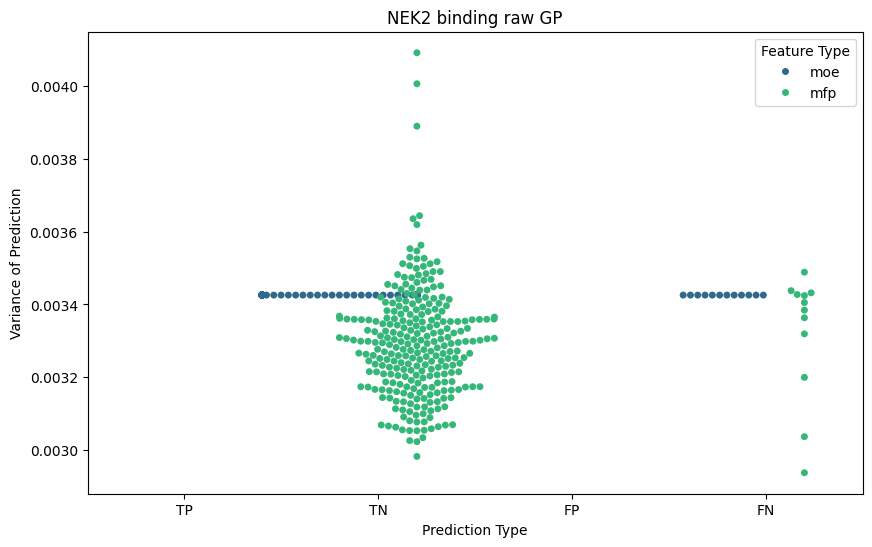

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 91.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 92.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


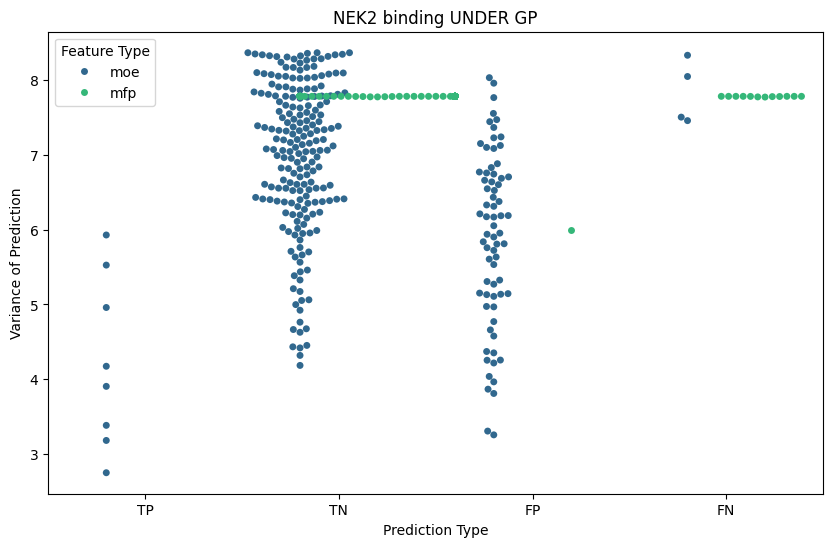

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 22.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 45.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 24.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 48.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 16.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 47.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 18.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 50.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


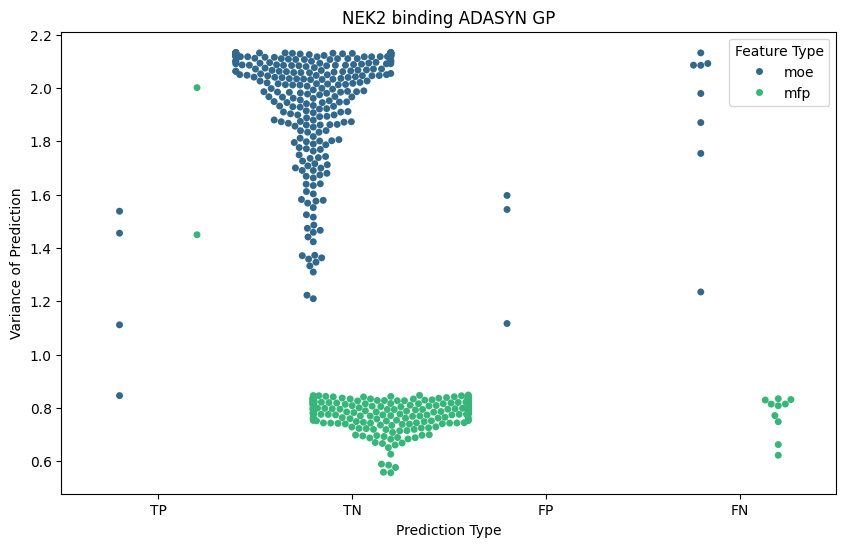

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 87.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 92.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


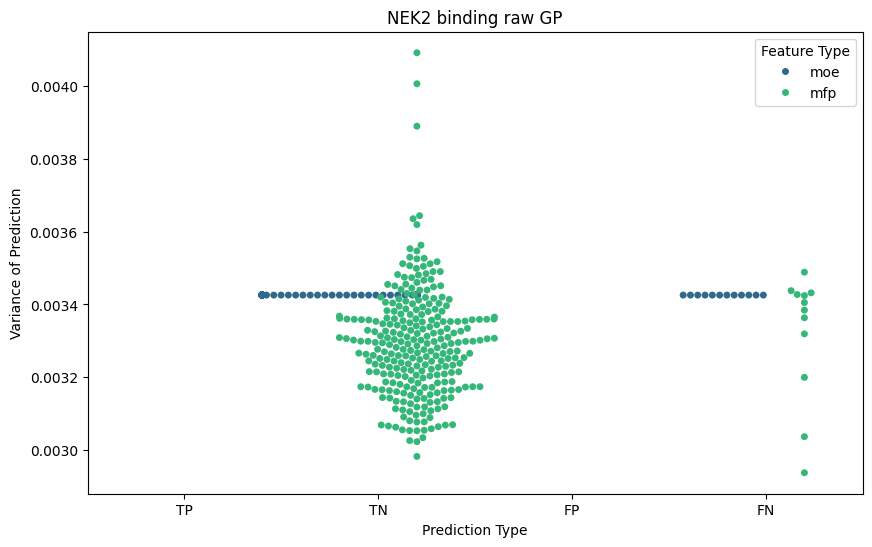

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 91.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 92.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


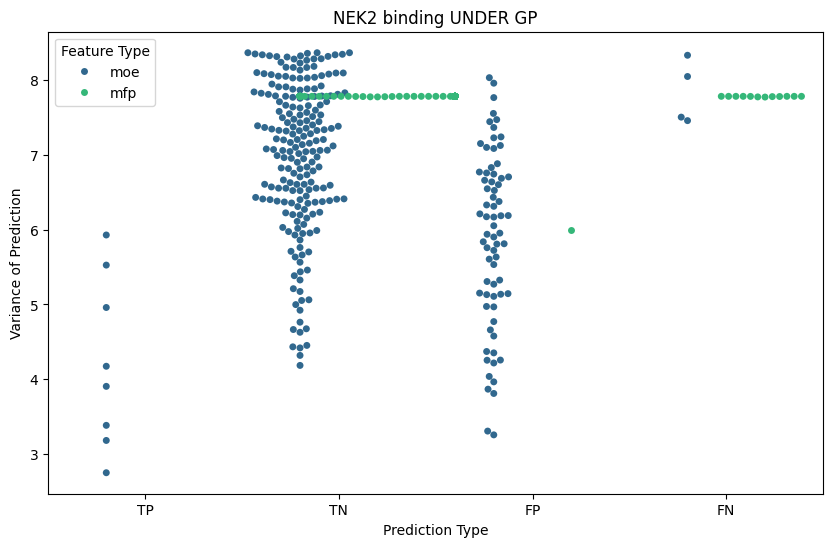

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 22.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 45.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 24.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 48.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


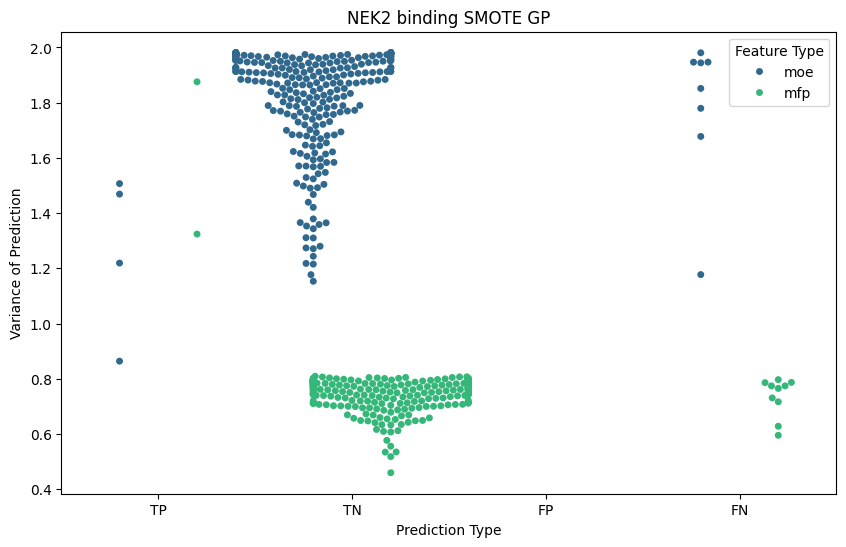

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 16.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 47.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 18.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 50.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


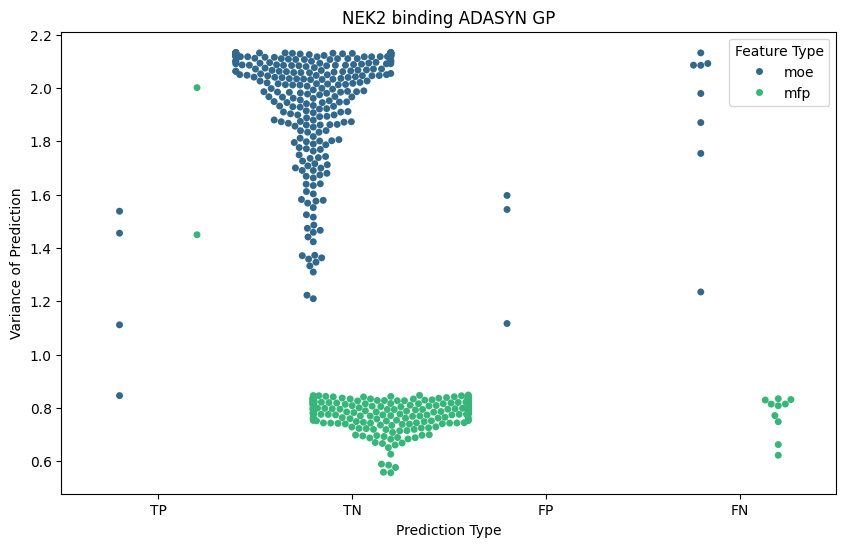

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 87.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 92.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


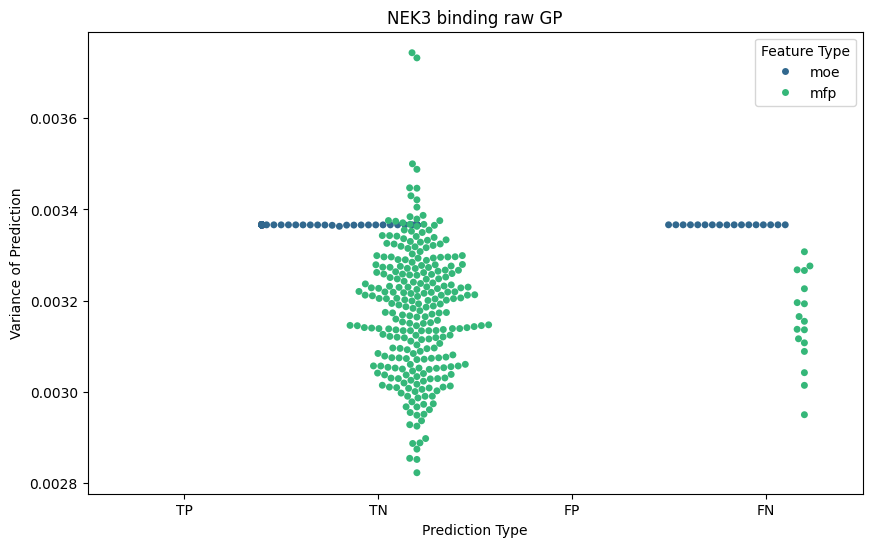

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 90.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 40.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 40.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 92.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi

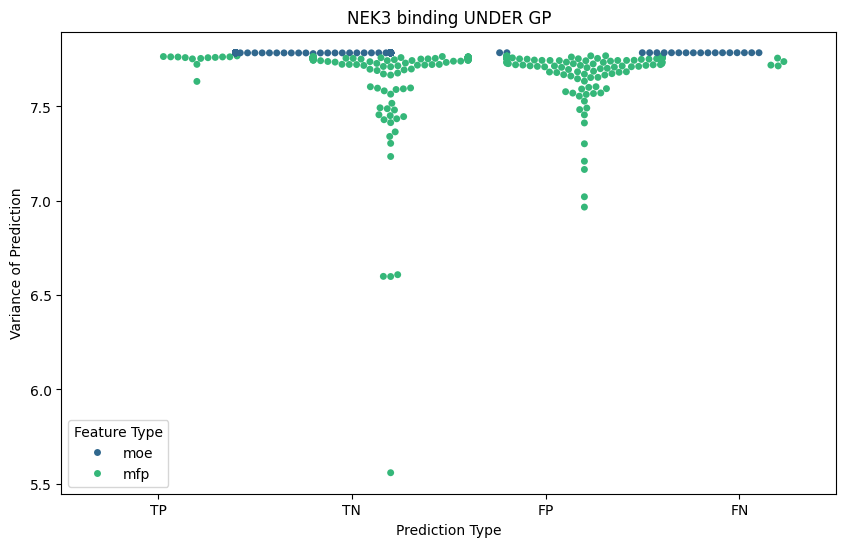

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 49.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 52.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


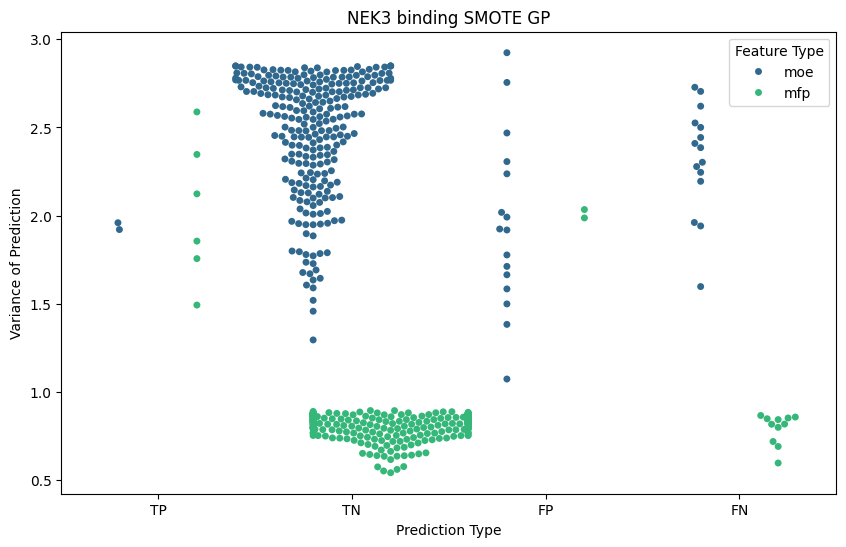

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 53.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 55.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


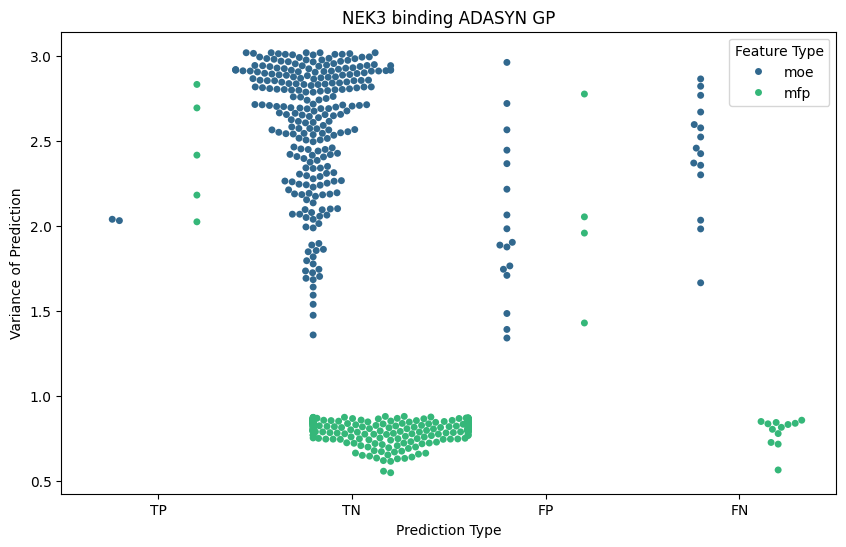

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 87.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 92.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


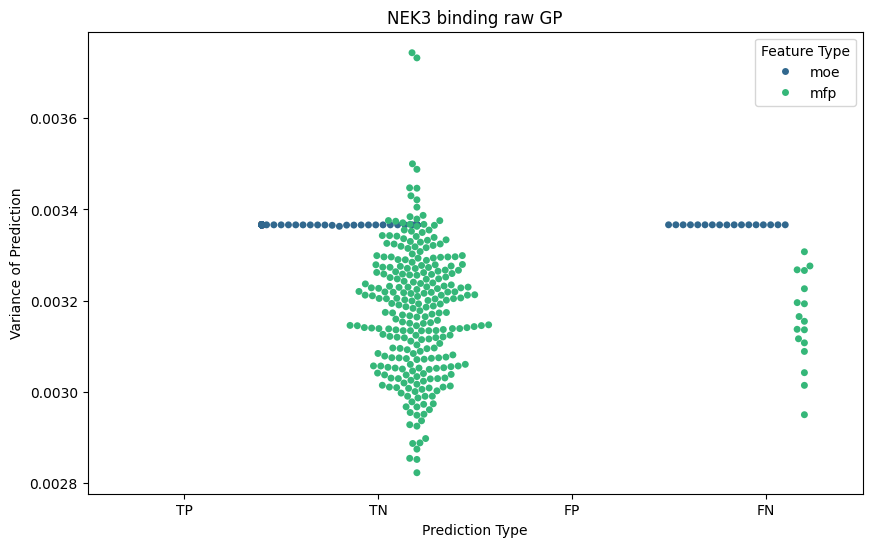

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 90.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 40.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 40.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 92.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi

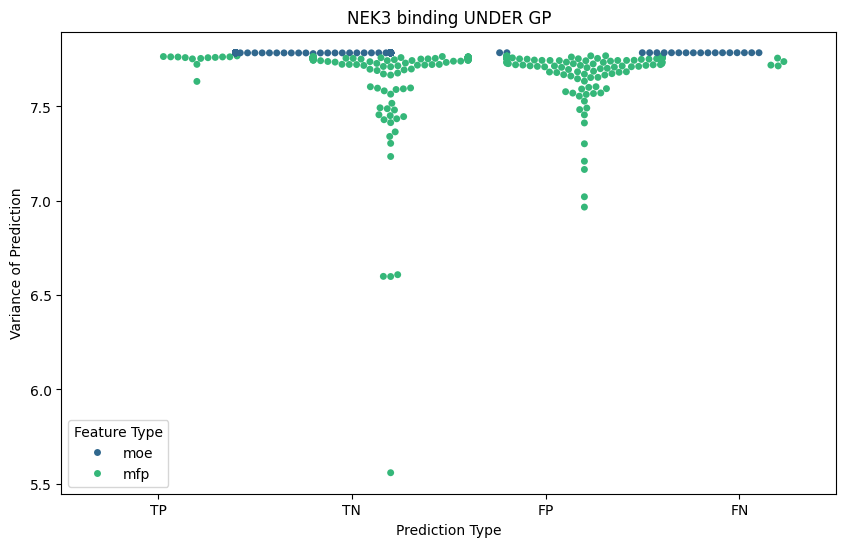

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 49.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 52.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


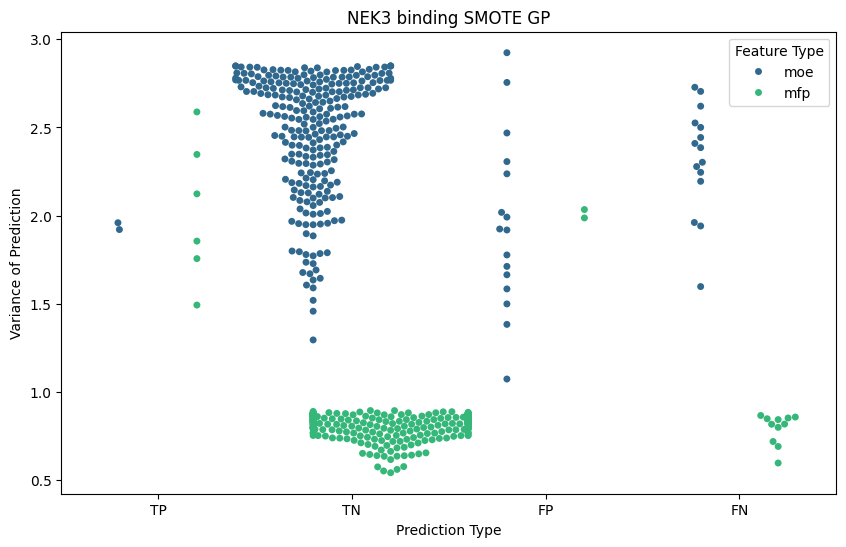

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 53.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 55.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


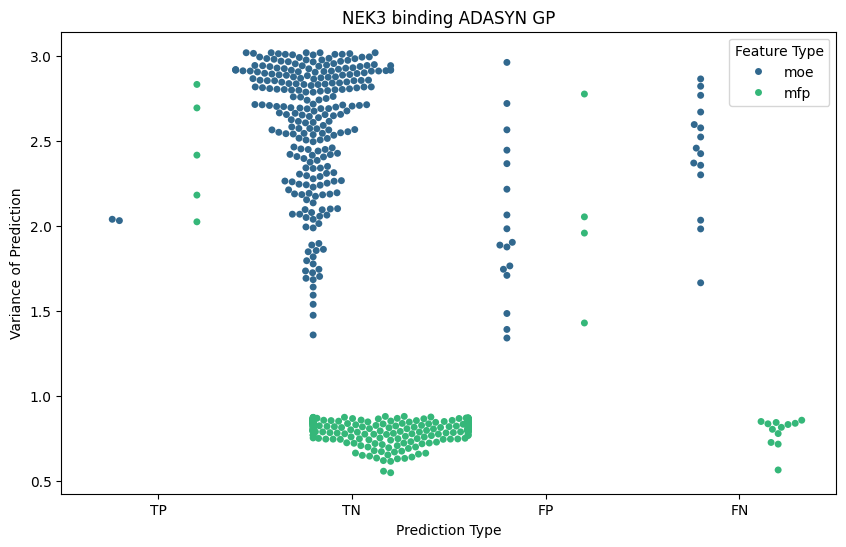

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 89.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 90.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


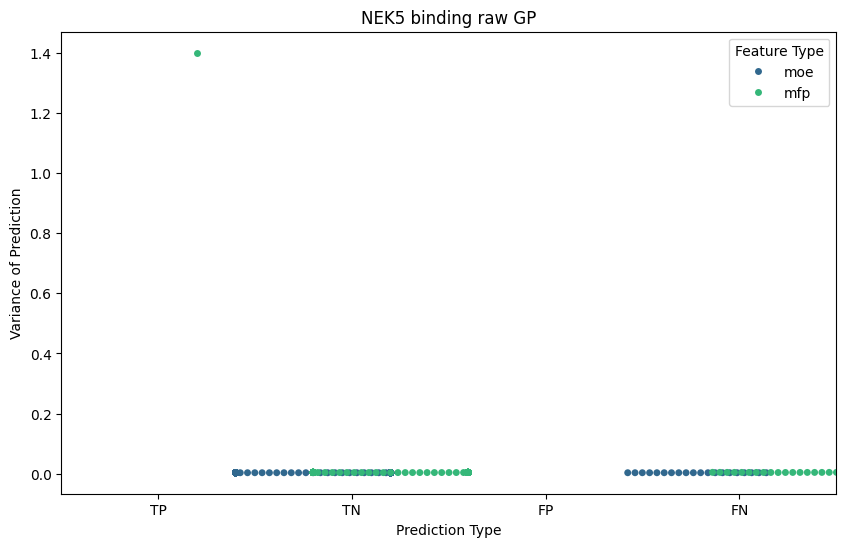

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 89.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 13.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 90.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


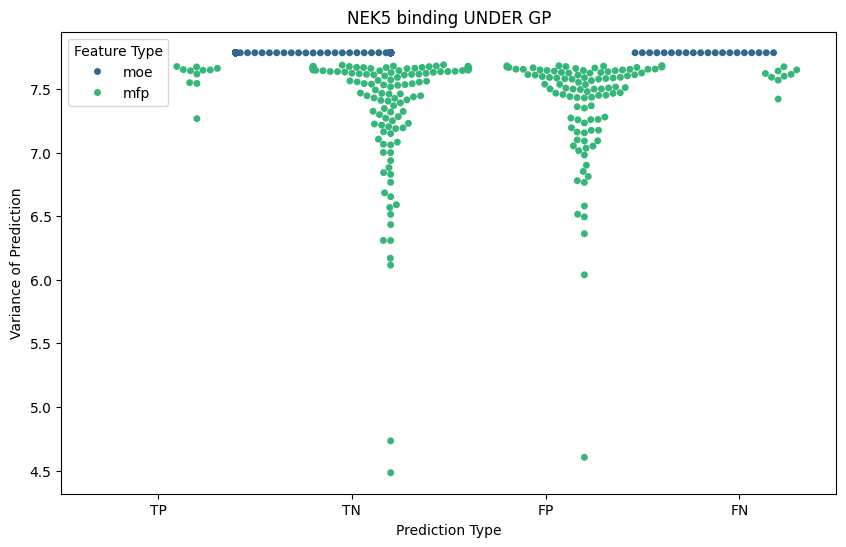

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 22.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 25.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


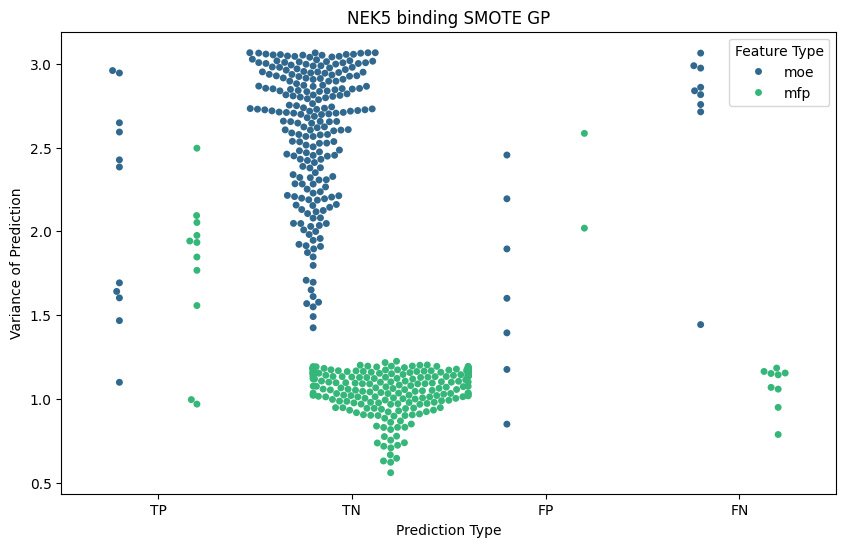

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 35.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 38.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


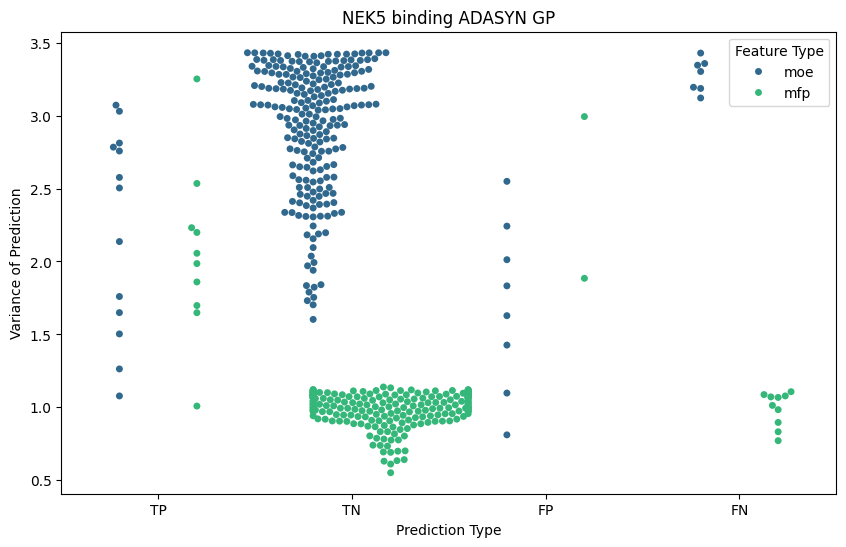

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 89.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 90.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


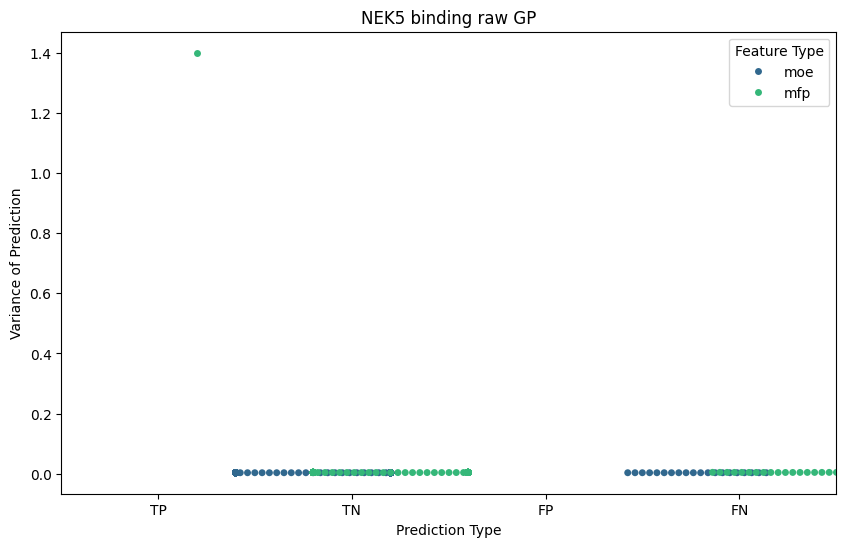

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 89.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 13.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 90.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


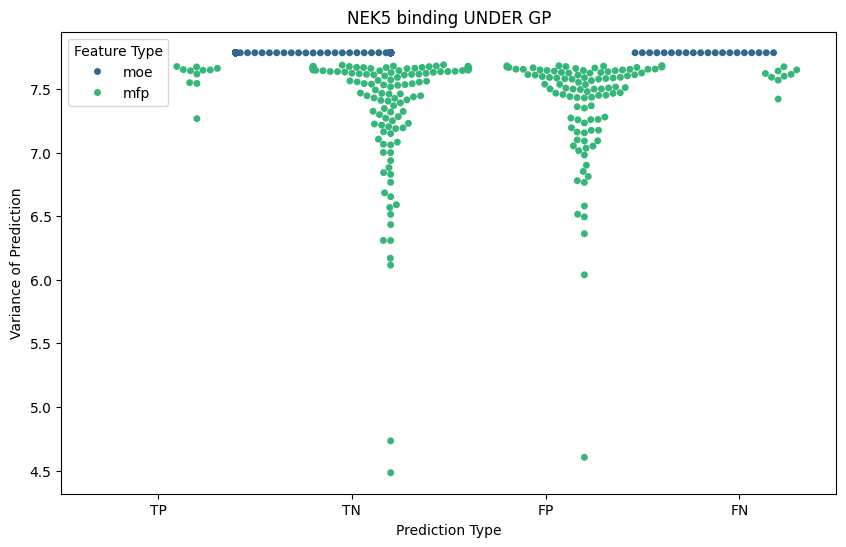

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 22.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 25.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


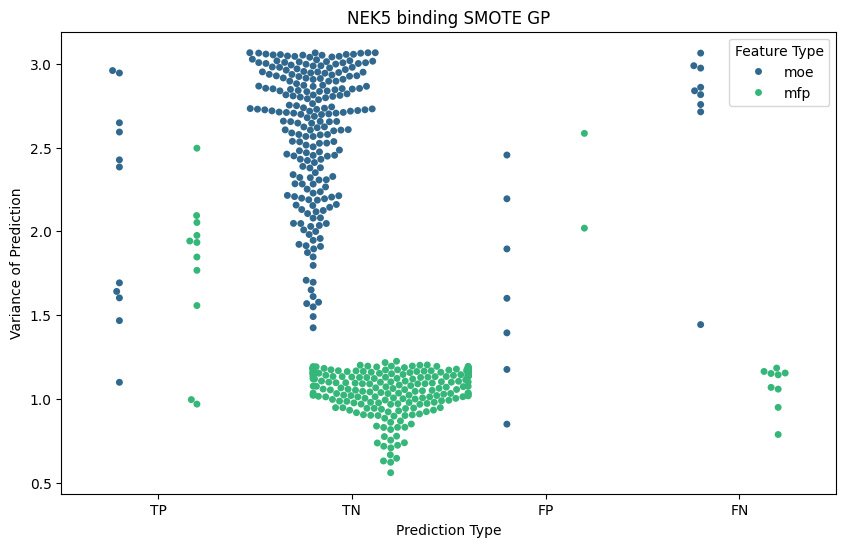

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 35.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 38.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


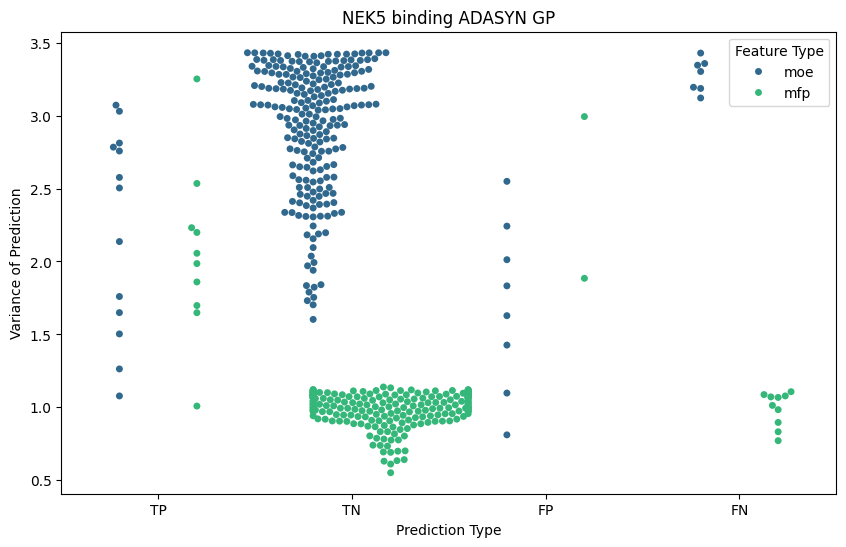

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 87.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 92.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


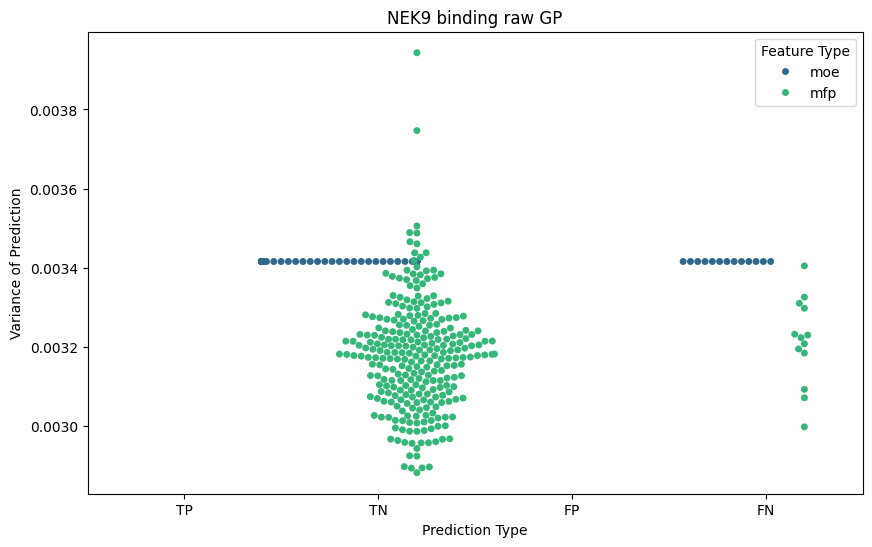

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 91.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 92.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


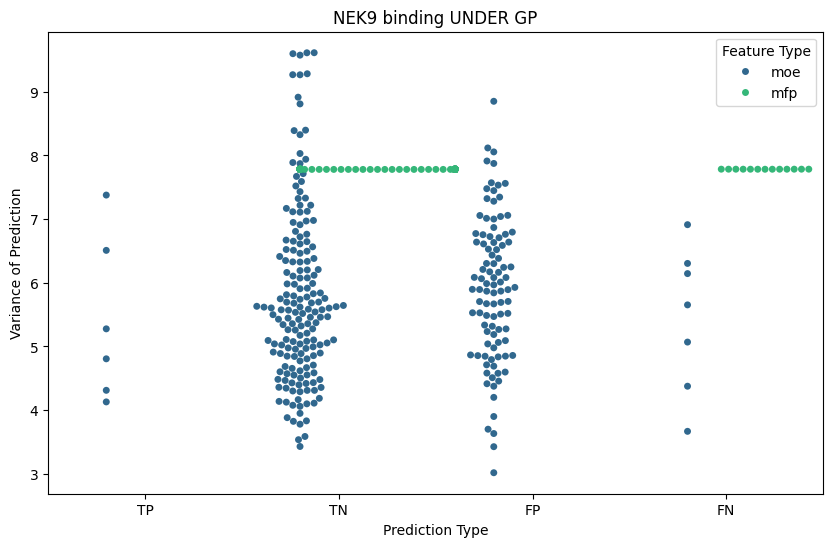

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 6.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 41.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 6.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 43.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


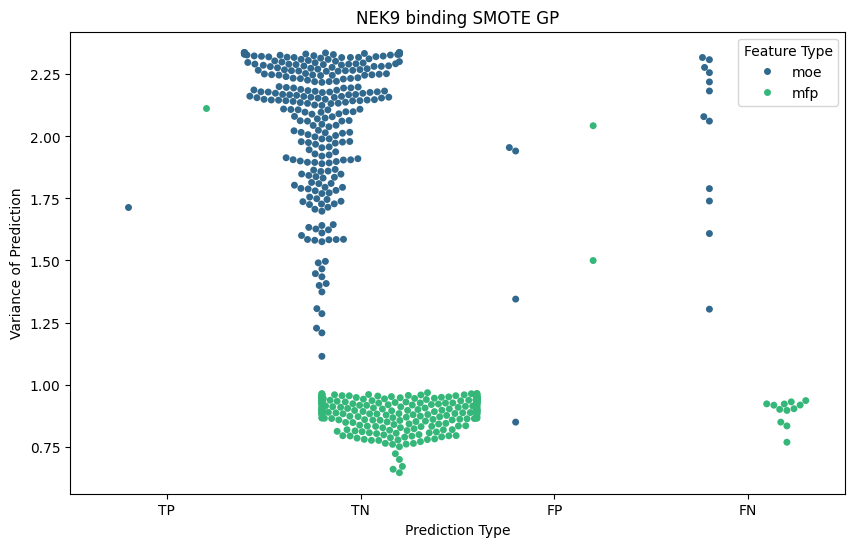

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 48.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 5.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


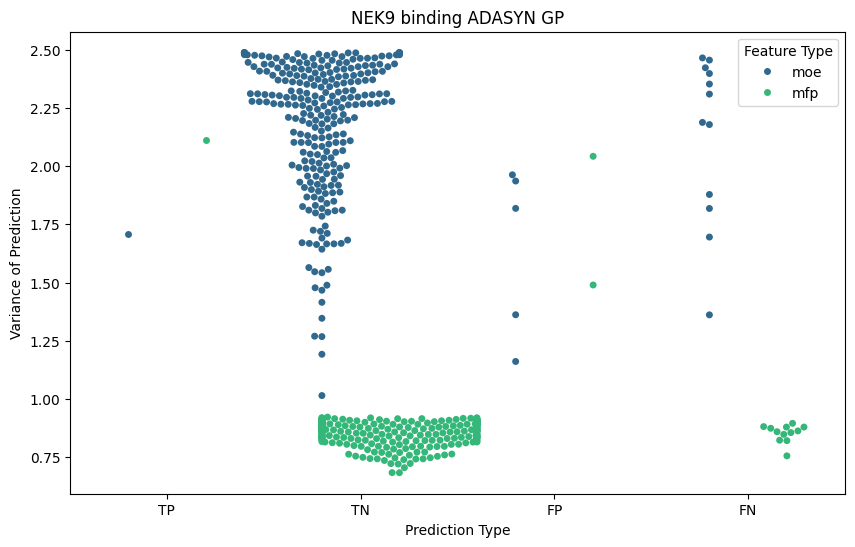

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 87.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 92.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


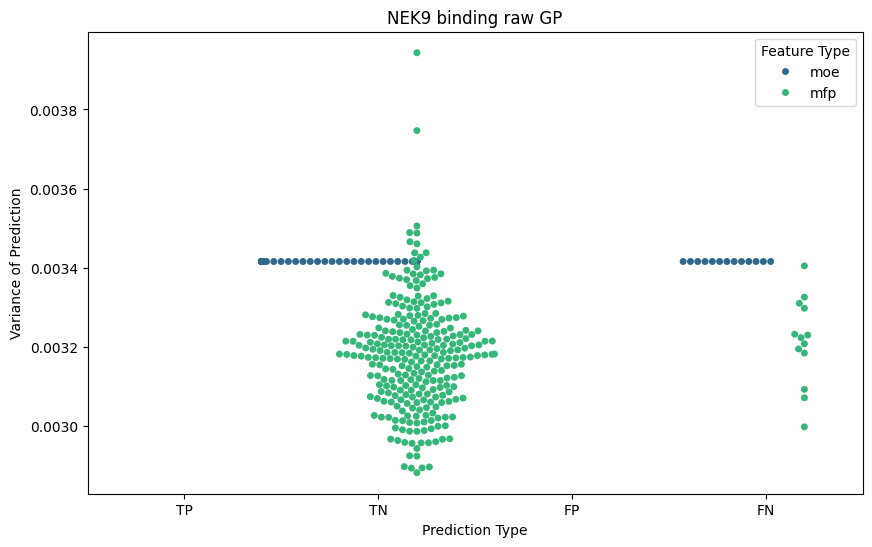

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 91.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 92.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


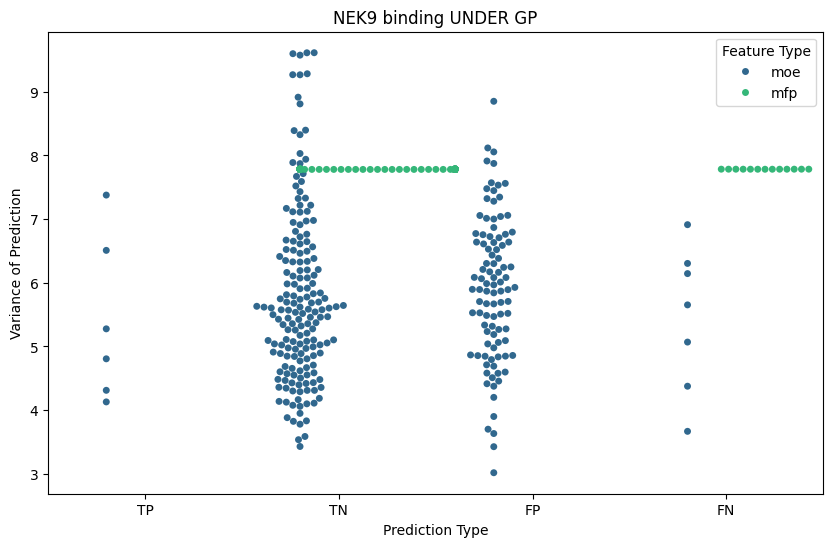

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 6.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 41.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 6.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 43.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


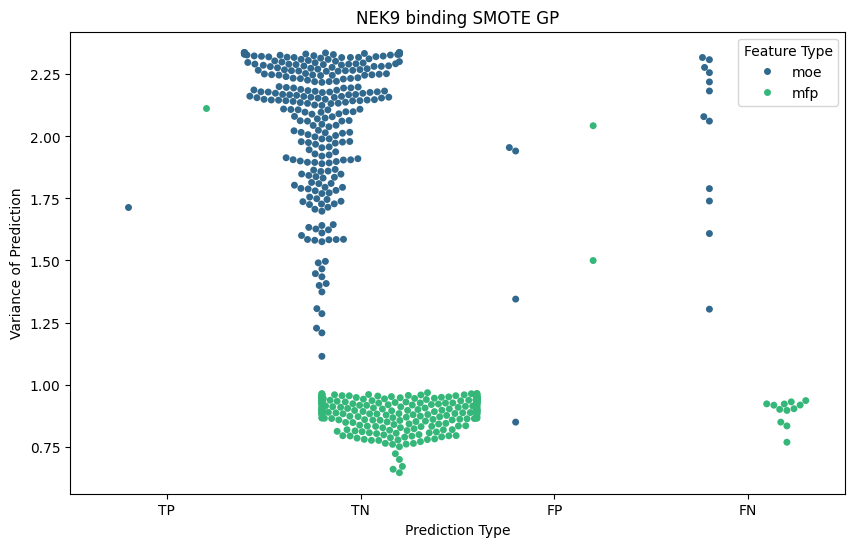

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 48.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 5.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


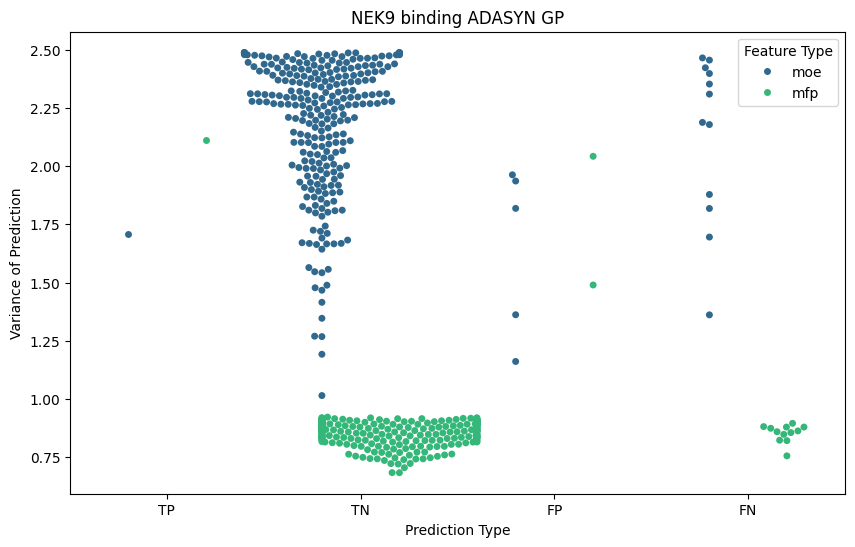

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def swarm_gp_moe_mfp(df, title, figure_path, filename):
    # Create a new column 'Varience of prediction' based on 'prediction_type'
    df['Varience of prediction'] = df.apply(
        lambda row: row['var0'] if row['prediction_type'] in ['TN', 'FN'] else row['var1'], axis=1
    )
    
    # Prepare data for plotting
    data = {
        'Varience of prediction': df['Varience of prediction'],
        'Prediction Type': df['prediction_type'],
        'Feature Type': df['feat_type']
    }
    plot_df = pd.DataFrame(data)
    category_order = ['TP', 'TN', 'FP', 'FN']
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    ax = sns.swarmplot(x='Prediction Type', y='Varience of prediction', hue='Feature Type', data=plot_df, order=category_order, dodge=True, palette="viridis", edgecolor='black')
    
    # Set plot labels and title
    plt.title(title)
    plt.xlabel('Prediction Type')
    plt.ylabel('Variance of Prediction')

    # # Save the plot if a path is provided
    # if figure_path is not None: 
    #     plt.savefig(f'{figure_path}{filename}.png')
        
    plt.show()

GPpath = '/Users/radhi/Desktop/CAPSTONE_DATA/GP_results/GP_result_df/'
col_names = ['prediction_type', 'ADdist', 'model_type']
model_palette = sns.cubehelix_palette(start=.5, rot=-.5, n_colors=2)
category_order = ['TP', 'TN', 'FP', 'FN']
figure_path = '/Users/radhi/Desktop/atom2024/atom2024/notebooks/NEK/plots/AD/figures/AD_GP_var/'

for nek in nek_list:
    for feat in feat_types: 
        for samp in samplings: 
            df_path = f'/Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK{nek}/bind/'
            full_df = pd.read_csv(f'{df_path}NEK{nek}_binding_{feat}_{samp}_df.csv') 
            train_df = full_df[full_df['subset'] == 'train'].select_dtypes(include=np.number).drop(columns=['active'])
            test_df = full_df[full_df['subset'] == 'test'].select_dtypes(include=np.number).drop(columns=['active'])

            moe_pred = pd.read_csv(f'{GPpath}NEK{nek}_binding_moe_{samp}_test_GP.csv')
            mfp_pred = pd.read_csv(f'{GPpath}NEK{nek}_binding_mfp_{samp}_test_GP.csv')
            var0_moe = moe_pred['var_pred_class0'].to_numpy()
            var1_moe = moe_pred['var_pred_class1'].to_numpy()
            var0_mfp = mfp_pred['var_pred_class0'].to_numpy()
            var1_mfp  = mfp_pred['var_pred_class1'].to_numpy()
            moe_preds = moe_pred['y_pred']
            mfp_preds = mfp_pred['y_pred']
    
            true_labels = moe_pred['y'].to_numpy()
            
            # Ensure lengths match by truncating test_dist
            test_dist_truncated = test_dist[:len(moe_preds)]

            moe_df = pd.DataFrame({'prediction': moe_preds, 'prediction_type': moe_pred['prediction_type'], 'var0': var0_moe, 'var1': var1_moe, 'ADdist': test_dist_truncated})
            mfp_df = pd.DataFrame({'prediction': mfp_preds, 'prediction_type': mfp_pred['prediction_type'], 'var0': var0_mfp, 'var1': var1_mfp, 'ADdist': test_dist_truncated})
            moe_df['feat_type'] = 'moe'
            mfp_df['feat_type'] = 'mfp' 

            if samp == 'scaled': 
                samp = 'raw'
            
            combined_df = pd.concat([moe_df, mfp_df], ignore_index=True)
            swarm_gp_moe_mfp(combined_df, f'NEK{nek} binding {samp} GP', figure_path, f'NEK{nek}_binding_{samp}_GP_AD')

            if samp == 'raw': 
                samp = 'scaled'
